![](https://i.postimg.cc/mg8dQz0M/1920px-Titanic-Starboard-View-1912.gif)

# 프로젝트명 : 타이타닉 생존 예측 모델 (베이스라인 토대로 작성)

* LS 빅데이터 스쿨 4조 김준희 박상준 박창순 박지원

## 분석 프로세스 

```
1. 데이터 확인
2. EDA(탐색적 데이터 분석) : 데이터 전처리
3. 데이터 학습셋 검증셋 분리
4. 모델 학습 및 평가
5. 모델 선택
```

## 가장 높은 점수 0.78468을 받았던 전처리 방법

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/Colab Notebooks'

# pycaret은 로컬(주피터, 아나콘다)에서 가상환경을 따로 설정하고 실행해야 가능한 점 참고부탁드립니다
# !pip install pycaret
# from pycaret.classification import *

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# load dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]
all_df = pd.concat([train_df, test_df.reset_index(drop=True)], axis=0)


# Auto-EDA -> Autoviz , Pandas profilling 통해 결측치 파악 및 결측치 보간 방법 정리

# 결측치 처리

## Embark 결측치 처리
all_df['Embarked'] = all_df['Embarked'].fillna('S')
train_df['Embarked'] = train_df['Embarked'].fillna('S')

## 갑판을 바탕으로 결측치 처리 및 범주화 Cabin -> Deck
all_df['Deck'] = all_df.Cabin.apply(lambda x: str(x)[0])
all_df['Deck']
train_df['Deck'] = train_df.Cabin.apply(lambda x: str(x)[0])
train_df['Deck']
test_df['Deck'] = test_df.Cabin.apply(lambda x: str(x)[0])
test_df['Deck']
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
all_df = all_df.drop(['Cabin'], axis=1)

train_df['Deck'] = train_df['Deck'].replace(['A','B','C'], 'ABC')
train_df['Deck'] = train_df['Deck'].replace(['D','E'], 'DE')
train_df['Deck'] = train_df['Deck'].replace(['F','G'], 'FG')
train_df['Deck'] = train_df['Deck'].replace(['n','T'], 'NT')
test_df['Deck'] = test_df['Deck'].replace(['A','B','C'], 'ABC')
test_df['Deck'] = test_df['Deck'].replace(['D','E'], 'DE')
test_df['Deck'] = test_df['Deck'].replace(['F','G'], 'FG')
test_df['Deck'] = test_df['Deck'].replace('n', 'NT')

## Age 결측치 처리

### median으로 결측치 처리
all_df['Age'].fillna(all_df['Age'].median(), inplace=True)
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

### 0세는 1세로 변환
all_df.loc[all_df.Age <= 1, 'Age'] = 1
train_df.loc[train_df.Age <= 1, 'Age'] = 1
test_df.loc[test_df.Age <= 1, 'Age'] = 1

### float 형을 int형으로 변환하는데 반올림 자동 실행
all_df['Age'] = all_df['Age'].astype('int')
train_df['Age'] = train_df['Age'].astype('int')
test_df['Age'] = test_df['Age'].astype('int')

## Fare 결측치 처리 -> 평균으로 하였음
all_df['Fare'] = all_df['Fare'].fillna(7.4917)
test_df['Fare'] = test_df['Fare'].fillna(7.4917)

## 생존과 연관이 없는 티켓 값 삭제
all_df = all_df.drop(['Ticket'], axis=1)
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
combine = [train_df, test_df]


# 파생변수 변환과정

## Name -> Title 이름에서 호칭만 뽑아내기 -> re 정규식 문법 사용하여 변환
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

## 작은 값 가진 호칭은 너무 많아서 하나로 정리하기 Rare
## Mrs, Miss, Master, Mr, Rare 5개 범주
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',
                                                 'Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev',
                                                 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

## train에서 PassengerId는 삭제하기
## Name도 쓰임을 다해 삭제하기
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

## SibSp + Parch + 1 = Family 
## Family는 0명이 많기 때문에 Alone으로 변환 
## 2명 이상 시 0, 1명은 1로 코딩              -> 동승자 여부
for dataset in combine:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['Alone'] = 0
    dataset.loc[dataset['Family'] == 1, 'Alone'] = 1

train_df = train_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
combine = [train_df, test_df]

## Age -> Age 범주화
## 동일 길이로 나누어서 범주를 만듦
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

## AgeBand 삭제
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

## Fare -> Fare 범주화 
## 동일 개수로 나누어서 범주를 만듦
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare']= 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']  = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

## FareBand 삭제
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]


# 인코딩 작업

## 인코딩 전 변수 정리

### 종속변수

#### 범주형 int 생존 여부 [Survived] 0, 1

### 독립변수

#### - 수치형 2

#### Age 이산형 데이터 범위 min max 설명 피룡
#### Fare 이산형임 데이터 범위 min max 설명 필요

### - 범주형 5

#### int 숫자형
#### Alone 0, 1                          :  동승자 여부 2명 이상 동승, 1명 승선, 서열 존재하지 않음
#### Pclass 0, 1, 2                      :  사회 경제적 지위 값 가격 3등실:0 , 2등실:1 , 1등실:2 , 서열 존재

#### object 문자형
#### Embarked S C Q                      :  S 영국 C 프랑스 Q 아일랜드, 서열 존재하지 않음
#### Deck A B C D E F G nT               :  갑판의 위치, n은 결측치, 서열 존재하지 않음
#### Title Mrs, Miss, Master, Mr, Rare   :  호칭, 서열 존재하지 않음


## Pclass -> 0 1 2 변환
train_df['Pclass'] = train_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)
test_df['Pclass'] = test_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)

## 데이터 원핫 인코딩 = 실제 동일 코드로 실행 시 라벨 인코딩보다 더 높은 점수를 보였음
encoded_train_data = pd.get_dummies(train_df)
encoded_test_data = pd.get_dummies(test_df)


## 데이터 정규화 - 로버스트 스케일링 이상치에 민감한 데이터에 널리 사용됨, 이상치에 강한 정규화 방법 boxplot과 연관 있음
from sklearn.preprocessing import StandardScaler, RobustScaler
rs = RobustScaler()

## Age -> Age_scaled 
## Age의 스케일이 다른 변수보다 커서 스케일링 시행함
encoded_train_data_scaled = encoded_train_data.copy(deep=True)
encoded_train_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_train_data_scaled[["Age"]])

encoded_test_data_scaled = encoded_test_data.copy(deep=True)
encoded_test_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_test_data_scaled[["Age"]])

### Age 삭제
encoded_train_data_scaled = encoded_train_data_scaled.drop("Age", axis=1)
encoded_test_data_scaled = encoded_test_data_scaled.drop("Age", axis=1)


# 데이터 분리 (학습 / 검증)

X_train = encoded_train_data_scaled.drop("Survived", axis=1)
Y_train = encoded_train_data_scaled["Survived"]
X_test  = encoded_test_data_scaled.drop("PassengerId", axis=1).copy()

from sklearn.model_selection import train_test_split

## train set 을 한번 더 나누어서 validation set 을 통해 미리 검증하여 모델 성능 개선 절차 시행
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.2, 
                                                  shuffle=True, random_state=777)


# 모델 학습 및 평가 

## 모델 성능 평가 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
def get_classfication_evalulator(y_test, pred):
    ## 오차행렬
    confusion = confusion_matrix(y_test, pred)
    ## 정확도
    accuracy = accuracy_score(y_test, pred)
    ## 정밀도
    precision = precision_score(y_test, pred)
    ## 재현율
    recall = recall_score(y_test, pred)
    ## F1 스코어
    f1 = f1_score(y_test, pred)
    print('------ 오차행렬 -------\n', confusion)
    print('\n정확도(accuracy): {:.4f}, 정밀도(precision): {:.4f}, 재현율(recall): {:.4f}, F1: {:.4f}'.format(accuracy, precision, recall, f1))
    print('---------------------\n')
    

## ROC_AUC 그래프 시각화 함수
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        pred_proba_c1 = model.predict_proba(X_test)[:, 1]
        fprs, tprs, _ = roc_curve(y_test, pred_proba_c1)
        roc_auc = roc_auc_score(y_test, pred_proba_c1)

        plt.plot(fprs, tprs, label=f'{model_name} (ROC_AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR (Recall)')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

## 1. 데이터 확인

In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]
all_df = pd.concat([train_df, test_df.reset_index(drop=True)], axis=0)
all_df.info()

In [ ]:
train_df.info()
print('_'*40)
print("")
test_df.info()

In [ ]:
print(train_df.shape)
print(test_df.shape)

In [ ]:
print(train_df.columns.values)

In [ ]:
# preview the data
train_df.head()

In [ ]:
train_df.tail()

## 2. EDA(탐색적 데이터 분석) : 데이터 전처리

In [ ]:
# # Auto-EDA 

# import ydata_profiling
# pr = all_df.profile_report() # 프로파일링 결과 리포트를 pr에 저장
# pr.to_file('./all_df_report.html') # pr_report.html 파일로 저장

In [ ]:
all_df.describe()
# 38.38%의 승객이 생존
# 50%의 승객이 28세 미만
# 40세 ~ 80세 승객 비율은 25% 미만
# 평균적으로 33달러 지불하고 탑승함

In [ ]:
all_df.describe(include=['O'])
# 탑승객 중 64.4% 남성
# Southampton에서 탑승한 승객이 70%로 가장 많음

### 수치형 - 수치형 상관관계 파악

#### 상관계수를 통해 변수 간의 상관관계를 파악할 수 있음

* 이를 통해 결측치 유형 파악 가능

* df.corr(method='pearson', min_periods=1)
* method : {pearson / kendall / spearman} 적용할 상관계수 방식입니다.
* min_periods : 유효한 결과를 얻기위한 최소 값의 수 입니다. 
* (피어슨, 스피어먼만 사용가능)

> * 피어슨 상관계수, 두 변수의 선형 상관계수
> * +1의 경우 완벽한 양의 선형 상관 관계
> * -1의 경우 완벽한 음의 상관관계
> * 0의 경우 선형 상관관계 X
> * 비율 척도가 적용되는 경우에는 피어슨 상관계수가 적용

> * 켄달-타우 상관계수, 두 순위간의 상관 계수

> * 스피어먼 상관계수, 두 변수의 순위의 피어슨 상관계수
> * 서열 척도가 적용되는 경우에는 스피어먼 상관계수
> * 두 변수가 선형관계가 아니어도 스피어먼 상관계수는 1이 될수 있음, 단순히 순위간의 상관계수이기 때문

In [ ]:
# 수치형 변수의 정규분포 확인-정규성 검정 선행
# 비모수적 방법 모수적 방법 상관분석 시행을 위함

# 귀무가설 H0 : 정규분포를 따른다.
# 대립가설 H1 : 정규분포를 따르지 않는다.
# p-value 값 기준 : 0.05 이상 -> H0 채택 / 이하 -> H0 기각

from scipy.stats import shapiro
print(shapiro(all_df.Age)) # 정규분포를 따름 모수 상관분석
print(shapiro(all_df.SibSp)) # 정규분포를 따르지 않음 비모수 상관분석
print(shapiro(all_df.Parch)) # 정규분포를 따르지 않음 비모수 상관분석
print(shapiro(all_df.Fare)) # 정규분포를 따름 모수 상관분석

# ShapiroResult(statistic=nan, pvalue=1.0)
# ShapiroResult(statistic=0.5110805034637451, pvalue=0.0)
# ShapiroResult(statistic=0.4979664087295532, pvalue=0.0)
# ShapiroResult(statistic=nan, pvalue=1.0)

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.distplot(all_df.Age, color = 'lightcoral')
plt.title("Age Histogram")
plt.show()

In [ ]:
sns.distplot(all_df.SibSp, color = 'lightcoral')
plt.title("SibSp Histogram")
plt.show()

In [ ]:
sns.distplot(all_df.Parch, color = 'lightcoral')
plt.title("Parch Histogram")
plt.show()

In [ ]:
sns.distplot(all_df.Fare, color = 'lightcoral')
plt.title("Fare Histogram")
plt.show()

In [ ]:
# 수치형 변수의 데이터 분포 비교를 위한 등분산 확인
# 등분산은 비교해야할 대상의 데이터의 분포가 서로 유사한지 살펴보는 것
# 데이터 분포가 서로 다르면 통계의 의미가 달라지기 때문

# 귀무가설 H0 : 두 그룹은 등분산을 만족한다.
# 대립가설 H1 : 두 그룹은 등분산을 만족하지 않는다.
# p-value 값 기준 : 0.05 이상 -> H0 채택 / 이하 -> H0 기각

from scipy.stats import bartlett
print(bartlett(all_df.Age, all_df.SibSp)) # 등분산 만족하지 않음
print(bartlett(all_df.Age, all_df.Parch)) # 등분산 만족하지 않음
print(bartlett(all_df.Age, all_df.Fare)) # 등분산 만족하지 않음

print(bartlett(all_df.SibSp, all_df.Parch)) # 등분산 만족
print(bartlett(all_df.SibSp, all_df.Fare)) # 등분산 만족하지 않음

print(bartlett(all_df.Parch, all_df.Fare)) # 등분산 만족하지 않음

# BartlettResult(statistic=5071.565420844084, pvalue=0.0)
# BartlettResult(statistic=5551.634425559788, pvalue=0.0)
# BartlettResult(statistic=1725.8173982062326, pvalue=0.0)
# BartlettResult(statistic=44.58827928944578, pvalue=2.4314287354209525e-11)
# BartlettResult(statistic=8402.089415220053, pvalue=0.0)
# BartlettResult(statistic=8886.039660235047, pvalue=0.0)

In [ ]:
sns.distplot(all_df.Age, color = 'lightcoral')
sns.distplot(all_df.SibSp, color = 'lightblue')
plt.show()

In [ ]:
sns.distplot(all_df.Age, color = 'lightcoral')
sns.distplot(all_df.Parch, color = 'lightblue')
plt.show()

In [ ]:
sns.distplot(all_df.Age, color = 'lightcoral')
sns.distplot(all_df.Fare, color = 'lightblue')
plt.show()

In [ ]:
sns.distplot(all_df.SibSp, color = 'lightcoral')
sns.distplot(all_df.Parch, color = 'lightblue')
plt.show()

In [ ]:
sns.distplot(all_df.SibSp, color = 'lightcoral')
sns.distplot(all_df.Fare, color = 'lightblue')
plt.show()

In [ ]:
sns.distplot(all_df.Fare, color = 'lightcoral')
sns.distplot(all_df.Parch, color = 'lightblue')
plt.show()

In [ ]:
# Sharpiro 정규성 검정과 Bartlett 등분산 검정을 통해 알 수 있는 정보
# 수치형 변수 중 Age - Fare의 경우 
# Pearson 상관계수와 Kendall, Spearman 상관계수 확인 가능

# 그러나 SibSp, Parch 의 경우 상관분석을 시행 시
# Pearson 불가 -> Kendall, Spearman 상관계수 확인 가능

In [ ]:
# 상관관계를 통해 변수간 상관성 도출
all_df[["Age","Fare"]].corr()

In [ ]:
corr = all_df[["Age","Fare"]].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Pearson Correlation")
plt.show()

In [ ]:
from scipy import stats
all_df[["Age","Fare"]].corr(method=lambda x, y : stats.pearsonr(x,y)[1])

In [ ]:
# Kendall's tau 는 두 변수 사이의 상관관계의 정도를 나타내는 지표
# 순위척도 자료형에 대한 상관계수 추론 방법
# 자료의 분포가 정규분포를 따르지 않아도 사용 가능
# -1과 1 사이의 값을 가짐, -1 or 1에 가까워질수록 예측할 수 있는 정도가 높아짐
# 즉, 예측도가 증가
all_df[["Age","SibSp","Parch","Fare"]].corr(method='kendall')

In [ ]:
corr = all_df[["Age","SibSp","Parch","Fare"]].corr(method='kendall')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Kendall's Tau Correlation")
plt.show()

In [ ]:
# Spearman correlation도 kendall과 동일
# 순위척도 자료형에 대한 상관계수 추론 방법
# 자료의 분포가 정규분포를 따르지 않아도 사용 가능
all_df[["Age","SibSp","Parch","Fare"]].corr(method='spearman')

In [ ]:
corr = all_df[["Age","SibSp","Parch","Fare"]].corr(method='spearman')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Spearman correlation")
plt.show()

In [ ]:
# Age - SibSp 데이터 분포 시각화
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')

font_size = 15
plt.scatter(all_df['Age'],all_df['SibSp'],color='lightcoral') ## 원 데이터 산포도

plt.xlabel('Age', fontsize=font_size)
plt.ylabel('SibSp',fontsize=font_size)
plt.show()

In [ ]:
## 선형 모형 적합
from scipy.stats import norm
from statsmodels.formula.api import ols

# 반응 변수 : SibSp
# 설명 변수 : Age

# R-squred : 0.059
# Adj R-squred : 0.058 -> 5.8% Goodness-of-fit 수정 설명력 낮음
# https://zephyrus1111.tistory.com/52

fit = ols('SibSp ~ Age',data = all_df).fit() # 단순선형회귀모형 적합
fit.summary()

In [ ]:
# Q-Q Plot
# 평균 : 0, 분산: 잔차의 분산 추정값을 따르는 정규분포의 이론적 분위수 사용
# 직선에 가까울 수록 오차의 정규성을 만족함

## 선형 모형 적합
# 반응 변수 : SibSp
# 설명 변수 : Age
fit = ols('SibSp ~ Age',data = all_df).fit() # 단순선형회귀모형 적합

## qq plot
sqrt_mse = np.sqrt(fit.mse_resid) ## square root of mse
 
num_const = 0.375 ## 백분위 분자 수정 계수
denom_const = 0.25 ## 백분위 분모 수정계수
 
## 오름차순으로 정렬했을 때 잔차의 순위
rank = [sorted(fit.resid).index(x)+1 for x in fit.resid] ## 인덱스가 0부터 시작하므로 1을 더한다.
 
expected_value = [] ## 이론적 잔차값
for i in range(len(fit.resid)):
    p = (rank[i]-num_const)/(len(fit.resid)+denom_const) ## 백분위
    expected_value.append(sqrt_mse*norm.ppf(p))

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
font_size = 15
# Q-Q Plot
plt.scatter(expected_value,fit.resid,color='lightblue') ## 잔차도 출력
plt.plot(expected_value,expected_value,color='lightcoral')
plt.xlabel('Expected', fontsize=font_size) # 잔차의 이론 값
plt.ylabel('Residual', fontsize=font_size) # 잔차 값
plt.show()

In [ ]:
# probplot 표준정규분포에서의 이론적 분위수 사용
# 직선에 가까울 수록 오차의 정규성을 만족함

from scipy.stats import probplot
 
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
ax = fig.add_subplot()
probplot(fit.resid, dist='norm',plot=ax) ## qq plot 출력
plt.show()

In [ ]:
# !pip install pingouin
import pingouin as pg

> *에 따라 다르게 바라볼 수 있음

> *p-value < 0.05 

> **p-value < 0.01 

> ***p-value < 0.001

> *이 많을 수록 더 Extraordinary 하다는 의미 (극단적이어야) Significant함

> 왼쪽 아래쪽은 r값을 오른쪽 위쪽에는 유의수준을 표시


In [ ]:
pg.rcorr(train_df[["Age","SibSp","Parch","Fare"]])

### 수치형 - 범주형 상관관계 파악

> * Point biserial correlation : 점이연 상관계수 
> * X변수가 연속형이고, Y변수는 이분변수
> * 이분 변수는 네 / 아니오, 있음 / 없음 형태 -> 0, 1로 코딩 후 
> * pearson 상관계수를 계산한 것 (해석이 pearson과 동일)

> * Biserial correlation : 
> * 위와 동일하나 이분변수가 원래 연속형변수를 이분화한 경우에 사용

> * Polyserial correlation : 
> * X변수가 연속형이고 Y변수의 범주화가 3개 이상인 경우에 사용

* 범주형 데이터는 수치형 변환 가능한 경우 더미변수화를 통해 분석에 사용

> * 서열형이 아님을 명심! 명목형 데이터임 -> 숫자에 의미가 없음
> * Survived   0 사망  1 생존            변환 필요 없음
> * Sex        0 male  1 female          변환 필요
> * Embarked   0 S     1 C      2 Q      변환 필요, 결측치 보간 후 더미변수화
> * Pclass     1 1등실 2 2등실  3 3등실  변환 필요 없음

> * [사용 X] PassengerId 승객 아이디
> * 변환 X 고유값으로 survived에 영향을 미치지 않음 사용 X

> * [사용 X, 파생변수화] Name 이름 
> * 변환 X 사람의 이름만 들어도 살지 못 살지 알 수 없으므로 사용 X
> * 이름에서 그 당시의 지위를 나타내는 성이 있어서
> * 성만 따로 추출하여 Title이라는 파생변수를 생성하여
> * 높은 지위를 가진 사람들이 더 잘 살아남았는지 판단이 가능
> * 실제로 지위가 높은 경우 요금도 비싼 요금의 객실을 살 수 있고, 
> * 1등실일 경우가 높음 -> 이에 대한 가설 검정 필요

> * [사용 X] Ticket 티켓 번호
> * 티켓 번호가 객실 위치와의 연관성은 없을 것으로 예상하며
> * 실제 구매할 때 순서대로 부여되는 고유값으로 판단하여 사용 X
> * 같이 구매한 사람들은 티켓 번호가 같을 수 있음
> * Parch, SibSp와 같은 가족과 한 번에 구매할 경우 
> 티켓 번호가 같을 수 있는데,
> * 가족이 아닌 경우에도 (하녀를 데리고 간다던가) 
> 티켓 번호가 같을 수 있기 때문에 의미가 없다고 판단하였음.
> * 파생변수 화 X

> * [사용 O, 파생변수화] Cabin 객실 번호 
> * 객실 위치로 생존과 관련성이 높음 
> * 탈출구 먼 곳이면 가까운 곳보다 물리적 거리가 떨어져 있어 
> 살아남기 힘들기 때문
> * 앞 letter가 갑판을 뜻하므로 letter만 떼어내서 범주형으로 변환
> * 결측치 처리 필요 (n - Null 으로 변환하였음)

In [ ]:
# Survived 0 사망 1 생존 변환 필요 없음
# Pclass 1 1등실 2 2등실 3 3등실 변환 필요

# Sex 0 male 1 female 변환 필요
# Embarked 0 S 1 C 2 Q 변환 필요, 결측치 보간 후 더미변수화

# train_df test_df는 변환하지 않고 all_df만 변환하여 관계만 파악함

#### Embarked 결측치 - 도메인 지식을 통해 대체 보간

* nan이 있을 시 수치형 변환이 되지 않기 때문에 먼저 시행하였음

In [ ]:
all_df[all_df['Embarked'].isna()]

In [ ]:
all_df['Embarked'] = all_df['Embarked'].fillna('S')
all_df[all_df['Embarked'].isna()]

In [ ]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')
train_df['Embarked'].isna().sum()

In [ ]:
# polyserial_correlation
# 3개 이상의 범주를 가지는 변수 분석을 위해
# !pip install RyStats --upgrade

In [ ]:
# from RyStats.inferential import correlation
# 사용 방법 찾아서 사용하기

### 범주형 - 범주형 상관관계 파악

> * 파이 계수(Phi coefficient)
> * X, Y변수 모두 남/여 또는 있다/없다 등 이분변수일 때
> * 두 변수간의 상관분석을 하는 방법
> * 파이 계수 대신 L, C, Lambda 등을 이용
> * 파이 계수의 상관계수 값은 0 ~ 1 사이의 범위를 갖고, 
> * 0에 가까울수록 상관관계가 낮으며
> * 1에 가까울수록 상관관계가 높다고 해석

> * 크래머 V계수(Cramer's V)
> * X, Y 변수의 범주가 3개 이상인 경우 상관분석을 하는 방법
> * 크래머 V계수를 사용
> * 크래머 V계수의 상관계수 값도 파이 계수와 동일하게 0 ~ 1 사이의 범위

In [ ]:
# from scipy.stats.contingency import association

# association(X, method="tschuprow")

In [ ]:
# association(obs4x2, method="cramer")

### 결측치 처리 ['Embarked'] ['Fare'] ['Cabin'] ['Age']

In [ ]:
import missingno as msno
msno.bar(all_df)

In [ ]:
msno.matrix(all_df)

In [ ]:
msno.matrix(all_df.sample(100))

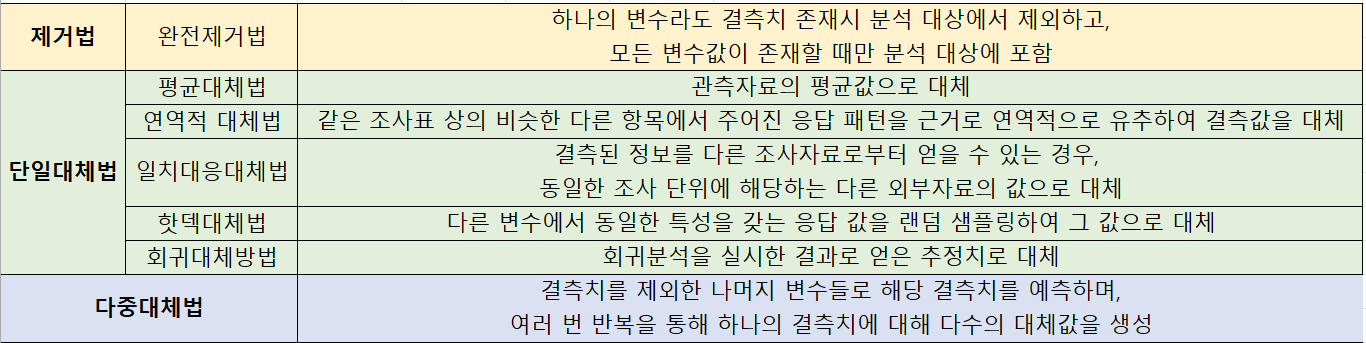

#### Cabin 결측치 처리

In [ ]:
print(all_df.Cabin.unique())
print(all_df.Cabin.nunique())

In [ ]:
# 공통 특징 뽑아내기
print(all_df[all_df['Cabin']=='E46'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='G6'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='D56'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='A6'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='B78'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C23 C25 C27'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C85'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C123'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C103'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C52'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C110'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C2'])
print('_'*40)
print("")
print(all_df[all_df['Cabin']=='C126'])
print('_'*40)
print("")
# Pclass Embarked 무조건 동일 Sex Ticket Fare 부분 동일 가능

In [ ]:
all_df.loc[(all_df.Cabin.isna())]

In [ ]:
# Pclass Embarked 무조건 동일 Sex Ticket Fare 부분 동일 가능
# 진행 불가로 삭제 예정
all_df.loc[(all_df.Pclass == 1) & (all_df.Embarked == 'S') |
          (all_df.Sex == 'male')].sort_values(by='Cabin').head(216)

In [ ]:
# 갑판을 바탕으로 범주화

all_df['Deck'] = all_df.Cabin.apply(lambda x: str(x)[0])
all_df['Deck']

In [ ]:
# n은 null 결측치 값을 뜻함
all_df['Deck'].unique()

In [ ]:
train_df['Deck'] = train_df.Cabin.apply(lambda x: str(x)[0])
train_df['Deck']

In [ ]:
# n은 null 결측치 값을 뜻함
train_df['Deck'].unique()

In [ ]:
test_df['Deck'] = test_df.Cabin.apply(lambda x: str(x)[0])
test_df['Deck']

In [ ]:
# n은 null 결측치 값을 뜻함
test_df['Deck'].unique()

In [ ]:
print(train_df['Deck'].isna().sum())
print(test_df['Deck'].isna().sum())
print(all_df['Deck'].isna().sum())

In [ ]:
pd.pivot_table(all_df,index='Survived',columns='Deck', values = 'Name', aggfunc='count')

In [ ]:
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
all_df = all_df.drop(['Cabin'], axis=1)
print(train_df.columns)
print(test_df.columns)
print(all_df.columns)

In [ ]:
pd.crosstab(train_df['Deck'], train_df['Sex'])

In [ ]:
pd.crosstab(train_df['Deck'], train_df['Pclass'])
## 1 - > 1등석

In [ ]:
pd.crosstab(train_df['Deck'], train_df['Survived'])

In [ ]:
# B = C > D > E 순으로 생존율이 가장 높음
# A, B, C는 전체 1등석
# D, E는 생존 비율이 비슷함
# 결측치 n이 가장 생존율이 낮음, 1명이 있는 T와 그룹핑
# F, G를 그룹핑하여 4개의 범주로 변환함

train_df['Deck'] = train_df['Deck'].replace(['A','B','C'], 'ABC')
train_df['Deck'] = train_df['Deck'].replace(['D','E'], 'DE')
train_df['Deck'] = train_df['Deck'].replace(['F','G'], 'FG')
train_df['Deck'] = train_df['Deck'].replace(['n','T'], 'NT')
pd.crosstab(train_df['Deck'], train_df['Survived'])

In [ ]:
pd.crosstab(test_df['Deck'], test_df['Pclass'])

In [ ]:
test_df['Deck'] = test_df['Deck'].replace(['A','B','C'], 'ABC')
test_df['Deck'] = test_df['Deck'].replace(['D','E'], 'DE')
test_df['Deck'] = test_df['Deck'].replace(['F','G'], 'FG')
test_df['Deck'] = test_df['Deck'].replace('n', 'NT')
pd.crosstab(test_df['Deck'], test_df['Pclass'])

#### Age 결측치 처리

In [ ]:
all_df[all_df['Age'].isna()]

In [ ]:
all_df.Age.unique()

In [ ]:
print(all_df.Age.nunique())

In [ ]:
# Kendall's tau 는 두 변수 사이의 상관관계의 정도를 나타내는 지표
# -1과 1 사이의 값을 가짐, -1 or 1에 가까워질수록 예측할 수 있는 정도가 높아짐
# 즉, 예측도가 증가

# age와 상관관계가 있는지 확인
# age와 높은 상관관계를 가지는 변수는 없음
# 다른 변수들과의 상관관계를 바탕으로 대체할 수 없다고 판단하여
# 중위수로 대체하였음

# 0 이하 값은 1로 대체
# 소수점 값은 전체 반올림하여 정수형으로 변환
# 범주화 진행 예정

all_df.loc[all_df.Age <= 1, 'Age'] = 1
all_df.loc[all_df.Age < 1]

train_df.loc[train_df.Age <= 1, 'Age'] = 1
train_df.loc[train_df.Age < 1]

test_df.loc[test_df.Age <= 1, 'Age'] = 1
test_df.loc[test_df.Age < 1]

In [ ]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
all_df['Age'].fillna(all_df['Age'].median(), inplace=True)

In [ ]:
train_df['Age'] = train_df['Age'].astype('int')
test_df['Age'] = test_df['Age'].astype('int')
all_df['Age'] = all_df['Age'].astype('int')

In [ ]:
train_df['Age'].info()

In [ ]:
train_df['Age'].unique()

In [ ]:
print(train_df.columns)
print(test_df.columns)
print(all_df.columns)

#### Fare 결측치 대체 보간

In [ ]:
all_df[all_df['Fare'].isna()]

In [ ]:
all_df['Fare']

In [ ]:
# 데이터의 기술 통계 확인

plt.hist(all_df['Fare'], bins=100, color='lightcoral')
plt.show()

In [ ]:
# 실제 512.3292 달러 낸 사람들은 다 살았음 (극단값이라고 삭제하면 안됨)
# 그러나 그 이하 사람들은 살았을 수도 있고 죽었을 수도 있음
# 돈을 많이 낸다고 무조건 사는지? 이를 알고 싶어짐

train_df[['Fare','Survived']][train_df['Fare'] >= 100].\
sort_values(by='Fare',ascending=False)

In [ ]:
# 티켓은 혼자 샀음
all_df[all_df['Ticket']=='3701']

In [ ]:
# 혼자 티켓 구매
all_df[all_df['Name']== 'Storey, Mr. Thomas']

In [ ]:
# 3등석 탄 사람은 709명
all_df[all_df['Pclass']==3]

In [ ]:
# 3등석 탄 사람은 916명
all_df[all_df['Embarked']=='S']

In [ ]:
# 탑승한 부모나 자녀가 없는 사람은 1002명
all_df[all_df['Parch'] == 0]

In [ ]:
# 3등석에서 동승자 없이 혼자 50대에서 70대 사이의 
# 영국 S에서 승선한 남자 사람들과 비슷하다고 생각하였음.
all_df.loc[(all_df.Parch == 0) & (all_df.Pclass == 3) & 
           (all_df.Embarked == 'S') & (all_df.SibSp == 0) & 
           (all_df.Age <= 70) & (all_df.Age >= 50) & (all_df.Sex == 'male')]

In [ ]:
# 평균
(7.25+8.05+8.05+6.2375+7.75+8.05+7.0542)/7

In [ ]:
# 중위수 6.2375,7.0542,7.25,7.75,8.05,8.05,8.05
7.75

In [ ]:
all_df['Fare'] = all_df['Fare'].fillna(7.4917)
all_df['Fare'].isna().sum()

In [ ]:
test_df['Fare'] = test_df['Fare'].fillna(7.4917)
test_df['Fare'].isna().sum()

In [ ]:
# Pclass가 낮을수록 요금이 감소하는 추세를 보임
# 음의 상관관계를 보이며 서로 영향을 미치고 있음
sns.regplot(data = train_df, x = 'Pclass', y = 'Fare', color = 'lightcoral');

In [ ]:
# Parch가 낮을수록 요금이 감소하는 추세를 보임
# 양의 상관관계를 보이며 서로 영향을 미치고 있음
sns.regplot(data = train_df, x = 'Parch', y = 'Fare', color = 'lightcoral');

In [ ]:
# Age가 낮을수록 요금이 감소하는 추세를 보임
# 양의 상관관계를 보이며 서로 영향을 미치고 있음
sns.regplot(data = train_df, x = 'Age', y = 'Fare', color = 'lightcoral');

In [ ]:
# 생존한 사람이 사망한 사람보다 요금이 높은 추세를 보임
# 양의 상관관계를 보이며 서로 영향을 미치고 있음
sns.regplot(data = train_df, x = 'Survived', y = 'Fare', color = 'lightcoral');

### SibSp, Parch 이상치 판단 및 데이터 탐색

In [ ]:
# 데이터의 기술 통계 확인

plt.hist(all_df['SibSp'], bins=16, color='lightcoral')
plt.show()

In [ ]:
# 데이터의 기술 통계 확인

plt.hist(all_df['Parch'], bins=18, color='lightcoral')
plt.show()

In [ ]:
test_df.info()

In [ ]:
train_df.info()

In [ ]:
all_df.info()

### EDA - FE 진행

In [ ]:
# 티켓 값 삭제
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
all_df = all_df.drop(['Ticket'], axis=1)
all_df.shape 

In [ ]:
train_df.shape, test_df.shape, train_df.columns, test_df.columns

In [ ]:
combine = [train_df, test_df]
combine

### Name -> Title 변환

* 이름에서 호칭만 분리하여 파생변수로 선언

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

* 1~7개의 상대적으로 적은 값을 가지는 호칭은 Rare 호칭으로 그룹핑하였음.

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',
                                                 'Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev',
                                                 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

In [ ]:
train_df['Title'].unique()

In [ ]:
# 이름 삭제, train에서 승객 ID 삭제

train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

### SibSp와 Parch를 합하면 가족이 되며 혼자 탑승한 사람인지 아닌지 알 수 있음

* 도메인 지식을 활용하여 새로운 파생변수를 만들어 모델 성능을 올릴 수 있음

In [ ]:
# 동승자가 없는 경우 -> Parch + SibSp = 0
# 그러나 자기 자신이 있기 때문에 1을 더하여 가족 1명을 기본 값으로 설정함

for dataset in combine:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['Family', 'Survived']].groupby(['Family'], as_index=False).\
mean().sort_values(by='Survived', ascending=False)

In [ ]:
# Family를 통해 승객이 혼자인 경우와 혼자가 아닌 경우로 나뉘게 됨
# 승객이 혼자인 경우 1, 승객이 여럿인 경우 0
# 이 또한 생존 예측에 있어 중요한 변수라 생각하여 파생변수를 만듦

for dataset in combine:
    dataset['Alone'] = 0
    dataset.loc[dataset['Family'] == 1, 'Alone'] = 1

train_df[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()

In [ ]:
train_df = train_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
combine = [train_df, test_df]

train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df.shape, test_df.shape

### Age 값의 범주화

* 값이 많기 때문에 비슷한 특징을 가진 값들을 그룹핑하여 모델의 성능을 높임
* train data만 시행함

In [ ]:
# 5개의 범주로 나누어 그룹핑 시행

train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).\
mean().sort_values(by='AgeBand', ascending=True)

In [ ]:
# 극간에 따라 값의 범주를 정의하여 서열화 함
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

In [ ]:
# AgeBand 삭제
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df.shape, test_df.shape

### 요금 값의 범주화

* 값이 많기 때문에 비슷한 특징을 가진 값들을 그룹핑하여 모델의 성능을 높임
* train_data만 시행

In [ ]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).\
mean().sort_values(by='FareBand', ascending=True)

In [ ]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare']= 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']  = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

In [ ]:
test_df.head()

In [ ]:
train_df.shape, test_df.shape

## 인코딩 작업

In [ ]:
# 서열형 변경 - 전체 데이터를 변경해야 함
# Pclass - 1등실 : 값이 큰 2으로 변환
# Pclass - 3등실 : 값이 작은 0으로 변환

train_df['Pclass'] = train_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)
train_df['Pclass']

In [ ]:
test_df['Pclass'] = test_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)
test_df['Pclass']

In [ ]:
print(train_df.head())
print('')
print('')
print(test_df.head())

In [ ]:
train_df.info()

### Pandas get_dummy 사용하여 범주형 변수를 수치형으로 변환

* Survived ->   사망: 0   생존: 1

* Pclass   ->   3등실: 0  2등실: 1  1등실: 2

* Age      ->   16 이하: 0   16 초과 32 이하: 1 
* 32 초과 48 이하: 2    48 초과 64 이하: 3     64 초과: 데이터 그대로

* Fare     ->   7.91 이하: 0  7.91 초과 14.454 이하 :1 
* 14.454 초과 31 이하: 2 31 초과: 3

* Alone    ->   승객이 여럿인 경우: 0, 승객이 혼자인 경우: 1

> * 원-핫 인코딩
> * Sex_female   Sex_male
> * Embarked_C   Embarked_Q   Embarked_S
> * Deck_ABC     Deck_DE      Deck_FG      Deck_NT
> * Title_Master Title_Miss   Title_Mr     Title_Mrs    Title_Rare

In [ ]:
encoded_train_data = pd.get_dummies(train_df)
encoded_train_data

In [ ]:
encoded_test_data = pd.get_dummies(test_df)
encoded_test_data

In [ ]:
encoded_train_data.columns, encoded_train_data.dtypes

## 범주형(수치형 변환, 이진 변수), 수치형 변수 상관 관계 분석 - 생존 여부를 중심으로

> * 'Survived' 

> * 'Age', 'Fare' 수치형 변수

> * 'Alone' 범주형 이진 변수

> * 'Sex_female', 'Sex_male' 범주형 이진 변수

> * 'Pclass' 범주형 3개 변수

> * 'Embarked_C', 'Embarked_Q', 'Embarked_S' 범주형 3개 변수

> * 'Deck_ABC', 'Deck_DE', 'Deck_FG', 'Deck_NT' 범주형 4개 변수

> * 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare' 범주형 5개 변수

In [ ]:
#'Survived', 'Pclass', 'Age', 'Fare', 'Alone', 
# 'Sex_female', 'Sex_male'
# 'Embarked_C', 'Embarked_Q', 'Embarked_S'
# 'Deck_ABC', 'Deck_DE', 'Deck_FG', 'Deck_NT'
# 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'

In [ ]:
# 범주형(수치형 변환, 이진 변수), 수치형 변수 상관 관계 분석
from scipy.stats import pointbiserialr

correlation, p_value = pointbiserialr(encoded_train_data['Survived'],
                                      encoded_train_data['Age'])

print('Correlation: ', correlation)
print('P-value: ', p_value)

In [ ]:
corr = encoded_train_data[["Age","Survived"]].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Pearson Correlation")
plt.show()

In [ ]:
encoded_train_data[["Age","Survived"]].\
corr(method=lambda x, y : stats.pearsonr(x,y)[1])

In [ ]:
corr = encoded_train_data[["Age","Survived"]].corr(method='kendall')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Kendall's Tau Correlation")
plt.show()

In [ ]:
# https://blog.naver.com/breezehome50/222353492058
rho, p_val =  stats.kendalltau(encoded_train_data["Age"],
                               encoded_train_data["Survived"])
print(f"correlation coefficient : {rho}, p-value : {p_val}")

In [ ]:
# 범주형(수치형 변환, 이진 변수), 수치형 변수 상관 관계 분석
from scipy.stats import pointbiserialr

correlation, p_value = pointbiserialr(encoded_train_data['Survived'],
                                      encoded_train_data['Fare'])

print('Correlation: ', correlation)
print('P-value: ', p_value)

In [ ]:
corr = encoded_train_data[["Fare","Survived"]].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Pearson Correlation")
plt.show()

In [ ]:
corr = encoded_train_data[["Fare","Survived"]].corr(method='kendall')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Kendall's Tau Correlation")
plt.show()

In [ ]:
rho, p_val =  stats.kendalltau(encoded_train_data["Fare"],
                               encoded_train_data["Survived"])
print(f"correlation coefficient : {rho}, p-value : {p_val}")

### Phi 이진 - 이진 상관 분석

* 매튜상관계수 (MCC ; matthews correlation coefficient)
* https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a

* -1 ~ +1 사이 값을 가지며, +1 완벽한 예측, 0 랜덤한 예측 , -1 완전 반대 예측

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(encoded_train_data['Survived'], encoded_train_data['Sex_female'])

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(encoded_train_data['Survived'], encoded_train_data['Sex_male'])

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(encoded_train_data['Survived'], encoded_train_data['Alone'])

### Cramer's V 이진 - 다중 클래스 상관 분석
 https://recipesds.tistory.com/entry/%EA%B5%90%EC%B0%A8%EB%B6%84%EC%84%9D%EC%9D%98-%EC%99%84%EC%84%B1-Cross-Tabulation-%CF%87%C2%B2-Testing-Cramer-V-%EC%97%B0%EA%B4%80%EB%8F%84

> 크래머 V 계수(Cramer's V) = √(X²/n) / min(c-1, r-1)
> X2: 카이제곱 통계량
> n: 표본 크기
> r: 행의 수
> c: 열의 수

> * χ² 값과 관련되어 있으니까 서로 독립일 때 
> * 기대했던 값과 차이가 많이 날 수록 더 연관되어 있다고 생각하는 것

> * 0: 두 명목형 변수(nomial variables)간에 아무런 관련성도 없다.
> * 1: 두 명목형 변수(nomial variables)간에 서로 강한 관련성이 있다.

* 'Pclass' 범주형 3개 변수
* 'Embarked_C', 'Embarked_Q', 'Embarked_S' 범주형 3개 변수
* 'Deck_ABC', 'Deck_DE', 'Deck_FG', 'Deck_NT' 범주형 4개 변수
* 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare' 범주형 5개 변수

In [ ]:
train_df_encoded = encoded_train_data[['Survived','Pclass']].copy(deep = True)
train_df_encoded

In [ ]:
# https://blog.naver.com/kthchunjae/222290570091

from sklearn import preprocessing
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    phi2 = stat / obs
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - (((k-1)*(r-1))/(obs - 1)))
    rcorr = r - ((r-1)**2)/(obs-1)
    kcorr = k - ((k-1)**2)/(obs-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

rows=[]

for var1 in train_df_encoded:
    col = []
    for var2 in train_df_encoded:
        cramers = cramers_V(encoded_train_data[var1],
                            encoded_train_data[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
cramers_train_df = pd.DataFrame(cramers_results, 
                  columns = train_df_encoded.columns, 
                  index = train_df_encoded.columns)
cramers_train_df

In [ ]:
mask = np.triu(np.ones_like(cramers_train_df))
sns.heatmap(cramers_train_df, annot=True, 
            cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Cramer's V Correlation")
plt.show()

In [ ]:
from sklearn import preprocessing
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) 
    # Cross table building
    stat = chi2_contingency(crosstab)[0] 
    # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    phi2 = stat / obs
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - (((k-1)*(r-1))/(obs - 1)))
    rcorr = r - ((r-1)**2)/(obs-1)
    kcorr = k - ((k-1)**2)/(obs-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

train_df_encoded = encoded_train_data[['Survived', 'Embarked_C',
                                       'Embarked_Q', 'Embarked_S' ]].\
copy(deep = True)
rows=[]
for var1 in train_df_encoded:
    col = []
    for var2 in train_df_encoded:
        cramers = cramers_V(encoded_train_data[var1],
                            encoded_train_data[var2]) # Cramer's V test
        col.append(round(cramers,2)) 
        # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
cramers_train_df = pd.DataFrame(cramers_results, 
                  columns = train_df_encoded.columns, 
                  index = train_df_encoded.columns)
cramers_train_df

In [ ]:
mask = np.triu(np.ones_like(cramers_train_df))
sns.heatmap(cramers_train_df, annot=True, 
            cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Cramer's V Correlation")
plt.show()

In [ ]:
from sklearn import preprocessing
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    # Cross table building
    stat = chi2_contingency(crosstab)[0] 
    # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    phi2 = stat / obs
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - (((k-1)*(r-1))/(obs - 1)))
    rcorr = r - ((r-1)**2)/(obs-1)
    kcorr = k - ((k-1)**2)/(obs-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

train_df_encoded = encoded_train_data[['Survived', 'Deck_ABC', 
                                       'Deck_DE', 'Deck_FG', 'Deck_NT']].\
copy(deep = True)
rows=[]
for var1 in train_df_encoded:
    col = []
    for var2 in train_df_encoded:
        cramers = cramers_V(encoded_train_data[var1],
                            encoded_train_data[var2]) # Cramer's V test
        col.append(round(cramers,2)) 
        # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
cramers_train_df = pd.DataFrame(cramers_results, 
                  columns = train_df_encoded.columns, 
                  index = train_df_encoded.columns)
cramers_train_df

In [ ]:
mask = np.triu(np.ones_like(cramers_train_df))
sns.heatmap(cramers_train_df, annot=True, 
            cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Cramer's V Correlation")
plt.show()

In [ ]:
from sklearn import preprocessing
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) 
    # Cross table building
    stat = chi2_contingency(crosstab)[0] 
    # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    phi2 = stat / obs
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - (((k-1)*(r-1))/(obs - 1)))
    rcorr = r - ((r-1)**2)/(obs-1)
    kcorr = k - ((k-1)**2)/(obs-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

train_df_encoded = encoded_train_data[['Survived', 'Title_Master', 
                                       'Title_Miss', 'Title_Mr', 
                                       'Title_Mrs', 'Title_Rare']].\
copy(deep = True)
rows=[]
for var1 in train_df_encoded:
    col = []
    for var2 in train_df_encoded:
        cramers = cramers_V(encoded_train_data[var1],
                            encoded_train_data[var2]) # Cramer's V test
        col.append(round(cramers,2)) 
        # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
cramers_train_df = pd.DataFrame(cramers_results, 
                  columns = train_df_encoded.columns, 
                  index = train_df_encoded.columns)
cramers_train_df

In [ ]:
mask = np.triu(np.ones_like(cramers_train_df))
sns.heatmap(cramers_train_df, annot=True, 
            cmap="coolwarm", vmax=1, vmin=-1, mask = mask)
plt.title("Cramer's V Correlation")
plt.show()

## 데이터 정규화, 표준화

In [ ]:
encoded_train_data.columns, encoded_train_data.dtypes, encoded_train_data.shape

In [ ]:
encoded_test_data.columns, encoded_test_data.dtypes, encoded_test_data.shape

In [ ]:
encoded_train_data.Age.unique()

In [ ]:
encoded_test_data.Age.unique()

In [ ]:
# Scale data 
# https://mkjjo.github.io/python/2019/01/10/scaler.html

from sklearn.preprocessing import StandardScaler, RobustScaler
ss = StandardScaler()
rs = RobustScaler()

encoded_test_data_scaled = encoded_test_data.copy(deep=True)

encoded_test_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_test_data_scaled[["Age"]])
encoded_test_data_scaled[["Age_scaled"]]

In [ ]:
encoded_test_data_scaled[["Age"]]

In [ ]:
encoded_train_data_scaled = encoded_train_data.copy(deep=True)

encoded_train_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_train_data_scaled[["Age"]])
encoded_train_data_scaled[["Age_scaled"]]

In [ ]:
encoded_train_data_scaled[["Age"]]

In [ ]:
encoded_train_data_scaled.columns, encoded_test_data_scaled.columns

In [ ]:
encoded_train_data_scaled = encoded_train_data_scaled.drop("Age", axis=1)
encoded_test_data_scaled = encoded_test_data_scaled.drop("Age", axis=1)
encoded_train_data_scaled.columns, encoded_test_data_scaled.columns

## 3. 데이터 학습셋 검증셋 분리

In [ ]:
encoded_train_data_scaled

In [ ]:
print(encoded_train_data_scaled.head())
print(encoded_test_data_scaled.head())

In [ ]:
X_train = encoded_train_data_scaled.drop("Survived", axis=1)
Y_train = encoded_train_data_scaled["Survived"]
X_test  = encoded_test_data_scaled.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

In [ ]:
from sklearn.model_selection import train_test_split

#train set 을 한번 더 나누어서 validation set 또한 만들어 낼 수 있습니다. 
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=777)

# 최종적으로 분할된 각 test, validation, test set 을 모두 출력 
print("x_train:", x_train)
print("y_train:", y_train)
print("x_val:", x_val)
print("y_val:", y_val)
print("X_test:", X_test)

In [ ]:
x_train.shape , y_train.shape , x_val.shape , y_val.shape

## 4. 모델 학습 및 평가


1. 의사결정트리 : DecisionTreeClassifier
2. 랜덤포레스트 : RandomForestClassifier
3. 로지스틱 회귀 : LogisticRegression

### 📌 분류모델 성능 평가

- 정확도(Accuracy) : 실제 데이터에서 예측 데이터가 얼마나 같은지 판단

- 오차행렬(Confusion Matrix) : TN(True Negative), FP(False Positive), FN(False Negative), TP(True Positive)

    - TN: `예측값`을 `N`egative 값 0으로 예측했고, 실제 값도 Negative 값 0
    - FP: `예측값`을 `P`ositive 값 1로 예측했고, 실제 값은 Negative 값 0
    - FN: `예측값`을 `N`egative 값 0으로 예측했고, 실제 값은 Positive 값 1
    - TP: `예측값`을 `P`ositive 값 1으로 예측했고, 실제 값도 Positive 값 1 일때
-     


- 정밀도(Precision) : 예측을 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율

- 재현율(Recall) : 실제 값이 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율

- F1 스코어 : 정밀도와 재현율이 밸런스 있게 한쪽으로 치우치지 않으면 수치가 높아지는 척도

- ROC AUC : 이진 분류 모델의 성능 측정하는 지표. 1에 가까울수록 좋음

 #### 모델 성능 평가 함수

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
def get_classfication_evalulator(y_test, pred):
    ## 오차행렬
    confusion = confusion_matrix(y_test, pred)
    ## 정확도
    accuracy = accuracy_score(y_test, pred)
    ## 정밀도
    precision = precision_score(y_test, pred)
    ## 재현율
    recall = recall_score(y_test, pred)
    ## F1 스코어
    f1 = f1_score(y_test, pred)
    print('------ 오차행렬 -------\n', confusion)
    print('\n정확도(accuracy): {:.4f}, 정밀도(precision): {:.4f}, 재현율(recall): {:.4f}, F1: {:.4f}'.format(accuracy, precision, recall, f1))
    print('---------------------\n')


#### ROC_AUC 그래프 시각화

In [ ]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        pred_proba_c1 = model.predict_proba(X_test)[:, 1]
        fprs, tprs, _ = roc_curve(y_test, pred_proba_c1)
        roc_auc = roc_auc_score(y_test, pred_proba_c1)

        plt.plot(fprs, tprs, label=f'{model_name} (ROC_AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR (Recall)')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=777)
rf_clf = RandomForestClassifier(random_state=777)
lr_clf = LogisticRegression(random_state=777)

# x_train, x_val, y_train, y_val
# X_train, X_test, y_train, y_test

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_val)
print('🌲 DecisionTreeClassifier 평가\n')
get_classfication_evalulator(y_val, dt_pred)

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_val)
print('🌳🌳 RandomForestClassifier 평가\n')
get_classfication_evalulator(y_val, rf_pred)


# LogisticRegression 학습/예측/평가
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_val)
print('🧐 LogisticRegression 평가')
get_classfication_evalulator(y_val, lr_pred)

### 모델 성능 시각화

- ROC_AUC는 일반적으로 1에 가까울수록 좋으므로, 0.83이 된 RandomForest가 좋음

In [ ]:
models = {
    'Logistic Regression': lr_clf,
    'Decision Tree': dt_clf,
    'Random Forest': rf_clf
}

plot_roc_curves(models, x_val, y_val)

## 4. 모델 선택

- 높은 모델인 RandomForestClassifier를 사용

In [ ]:
# x_train, x_val, y_train, y_val
# X_train, X_test, y_train, y_test
### 전체 데이터 학습
rf_clf.fit(X_train, Y_train)

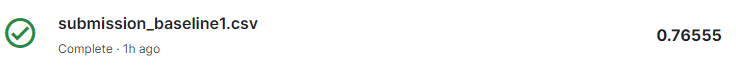

## GridSearchCV 적용 대표 점수 및 전처리 방법 정리 Kaggle_Score 0.78468

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]
all_df = pd.concat([train_df, test_df.reset_index(drop=True)], axis=0)

# Embark 결측치 처리
all_df['Embarked'] = all_df['Embarked'].fillna('S')
train_df['Embarked'] = train_df['Embarked'].fillna('S')

# 갑판을 바탕으로 범주화
all_df['Deck'] = all_df.Cabin.apply(lambda x: str(x)[0])
all_df['Deck']
train_df['Deck'] = train_df.Cabin.apply(lambda x: str(x)[0])
train_df['Deck']
test_df['Deck'] = test_df.Cabin.apply(lambda x: str(x)[0])
test_df['Deck']
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
all_df = all_df.drop(['Cabin'], axis=1)

train_df['Deck'] = train_df['Deck'].replace(['A','B','C'], 'ABC')
train_df['Deck'] = train_df['Deck'].replace(['D','E'], 'DE')
train_df['Deck'] = train_df['Deck'].replace(['F','G'], 'FG')
train_df['Deck'] = train_df['Deck'].replace(['n','T'], 'NT')
test_df['Deck'] = test_df['Deck'].replace(['A','B','C'], 'ABC')
test_df['Deck'] = test_df['Deck'].replace(['D','E'], 'DE')
test_df['Deck'] = test_df['Deck'].replace(['F','G'], 'FG')
test_df['Deck'] = test_df['Deck'].replace('n', 'NT')

# Age 결측치 처리
all_df.loc[all_df.Age <= 1, 'Age'] = 1
train_df.loc[train_df.Age <= 1, 'Age'] = 1
test_df.loc[test_df.Age <= 1, 'Age'] = 1

all_df['Age'].fillna(all_df['Age'].median(), inplace=True)
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

all_df['Age'] = all_df['Age'].astype('int')
train_df['Age'] = train_df['Age'].astype('int')
test_df['Age'] = test_df['Age'].astype('int')

# Fare 결측치 처리
all_df['Fare'] = all_df['Fare'].fillna(7.4917)
test_df['Fare'] = test_df['Fare'].fillna(7.4917)

# 티켓 값 삭제
all_df = all_df.drop(['Ticket'], axis=1)
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
combine = [train_df, test_df]

# 파생변수 변환과정

# Name -> Title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',
                                                 'Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev',
                                                 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

# SibSp + Parch + 1 = Family, 1 -> Alone 
for dataset in combine:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['Alone'] = 0
    dataset.loc[dataset['Family'] == 1, 'Alone'] = 1

train_df = train_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
combine = [train_df, test_df]

# Age -> Age 범주화
# 동일 길이로 나누어서 범주를 만듦
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

# AgeBand 삭제
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

# Fare -> Fare 범주화 
# 동일 개수로 나누어서 범주를 만듦
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare']= 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']  = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

# FareBand 삭제
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

# 인코딩 작업

# Pclass
train_df['Pclass'] = train_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)
test_df['Pclass'] = test_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)

# 데이터 원핫 인코딩
encoded_train_data = pd.get_dummies(train_df)
encoded_test_data = pd.get_dummies(test_df)


# 데이터 정규화
from sklearn.preprocessing import StandardScaler, RobustScaler
rs = RobustScaler()

encoded_train_data_scaled = encoded_train_data.copy(deep=True)
encoded_train_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_train_data_scaled[["Age"]])

encoded_test_data_scaled = encoded_test_data.copy(deep=True)
encoded_test_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_test_data_scaled[["Age"]])

# Age 삭제
encoded_train_data_scaled = encoded_train_data_scaled.drop("Age", axis=1)
encoded_test_data_scaled = encoded_test_data_scaled.drop("Age", axis=1)


# 데이터 분리 (학습 / 검증)
X_train = encoded_train_data_scaled.drop("Survived", axis=1)
Y_train = encoded_train_data_scaled["Survived"]
X_test  = encoded_test_data_scaled.drop("PassengerId", axis=1).copy()

from sklearn.model_selection import train_test_split

#train set 을 한번 더 나누어서 validation set 또한 만들어 낼 수 있습니다. 
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.2, 
                                                  shuffle=True, random_state=777)


## 모델 학습 및 평가 
# 모델 성능 평가 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
def get_classfication_evalulator(y_test, pred):
    ## 오차행렬
    confusion = confusion_matrix(y_test, pred)
    ## 정확도
    accuracy = accuracy_score(y_test, pred)
    ## 정밀도
    precision = precision_score(y_test, pred)
    ## 재현율
    recall = recall_score(y_test, pred)
    ## F1 스코어
    f1 = f1_score(y_test, pred)
    print('------ 오차행렬 -------\n', confusion)
    print('\n정확도(accuracy): {:.4f}, 정밀도(precision): {:.4f}, 재현율(recall): {:.4f}, F1: {:.4f}'.format(accuracy, precision, recall, f1))
    print('---------------------\n')
    

# ROC_AUC 그래프 시각화
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        pred_proba_c1 = model.predict_proba(X_test)[:, 1]
        fprs, tprs, _ = roc_curve(y_test, pred_proba_c1)
        roc_auc = roc_auc_score(y_test, pred_proba_c1)

        plt.plot(fprs, tprs, label=f'{model_name} (ROC_AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR (Recall)')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

dt_param_grid = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 5, 8]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 7, 10, 20],
    'min_samples_split': [2, 3, 6],
    'min_samples_leaf': [1, 5, 6, 8]
}

lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'max_iter': [500, 700, 1000]
}


grid_dt_clf = GridSearchCV(dt_clf, param_grid=dt_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_rf_clf = GridSearchCV(rf_clf, param_grid=rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_lr_clf = GridSearchCV(lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=5, n_jobs=-1)


grid_dt_clf.fit(x_train, y_train)
grid_rf_clf.fit(x_train, y_train)
grid_lr_clf.fit(x_train, y_train)

print('Decision Tree - GridSearchCV 최적 하이퍼 파라미터:', grid_dt_clf.best_params_)
print('Decision Tree - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dt_clf.best_score_))

print('Random Forest - GridSearchCV 최적 하이퍼 파라미터:', grid_rf_clf.best_params_)
print('Random Forest - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rf_clf.best_score_))

print('Logistic Regression - GridSearchCV 최적 하이퍼 파라미터:', grid_lr_clf.best_params_)
print('Logistic Regression - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lr_clf.best_score_))


best_dt_clf = grid_dt_clf.best_estimator_
best_rf_clf = grid_rf_clf.best_estimator_
best_lr_clf = grid_lr_clf.best_estimator_


dt_predictions = best_dt_clf.predict(x_val)
rf_predictions = best_rf_clf.predict(x_val)
lr_predictions = best_lr_clf.predict(x_val)

dt_accuracy = accuracy_score(y_val, dt_predictions)
rf_accuracy = accuracy_score(y_val, rf_predictions)
lr_accuracy = accuracy_score(y_val, lr_predictions)

print('Decision Tree - 테스트셋에서 정확도: {0:.4f}'.format(dt_accuracy))
print('Random Forest - 테스트셋에서 정확도: {0:.4f}'.format(rf_accuracy))
print('Logistic Regression - 테스트셋에서 정확도: {0:.4f}'.format(lr_accuracy))

In [ ]:
# DecisionTreeClassifier 학습/예측/평가

print('🌲 DecisionTreeClassifier 평가\n')
get_classfication_evalulator(y_val, dt_predictions)

# RandomForestClassifier 학습/예측/평가

print('🌳🌳 RandomForestClassifier 평가\n')
get_classfication_evalulator(y_val, rf_predictions)

# LogisticRegression 학습/예측/평가

print('🧐 LogisticRegression 평가')
get_classfication_evalulator(y_val, lr_predictions)

In [ ]:
models = {
    'Logistic Regression': best_lr_clf,
    'Decision Tree': best_dt_clf,
    'Random Forest': best_rf_clf
}


plot_roc_curves(models, x_val, y_val)

In [ ]:
## best_rf_clf 로 예측
pred = best_rf_clf.predict(X_test)


## 예측 결과를 Survived 컬럼으로 입력한다.
X_test['Survived'] = pred

## 예측 결과를 PassengerId와 Survived 컬럼으로만 제한해 CSV 파일로 저장한다.
X_test['PassengerId'] = test_df["PassengerId"]
submission = X_test[['PassengerId','Survived']]
submission.to_csv('submission_baseline2.csv', index=False) 

## 0.78468 점수를 얻었다.

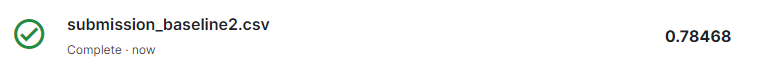

In [ ]:
# Pickle 형으로 모델을 꺼내는 joblib 사용하여 실제 모델을 배포할 수 있음

import joblib

joblib.dump(grid_rf_clf,'best_rf_model.pkl')
# grid_rf_clf.predict(X,y)

loaded_model = joblib.load('best_rf_model.pkl')

score = loaded_model.score(X_train,Y_train)
print('정확도: {score:.3f}'.format(score=score))

In [ ]:
# 실제 인물 데이터를 넣으면 어떻게 되는지 정리 및 예측

# 변환 작업 먼저 시행 필요

# 실제 데이터
# Pclass Name               Sex   Age SibSp Parch Ticket Fare Cabin Embarked
# 3      Master.Jack Dawson male  20  0     0     Jack    8   None   S
# 1      Miss. Rose DeWitt female 17  1     0     Rose   247  B58    C

# 코딩
# Pclass     Title       Sex   Age스케일링 Alone  Fare Deck      Embarked
# 0      Title_Master Sex_male  1    1     1   Deck_NT   Embarked_S
# 2      Title_Miss Sex_female 1    0     3  Deck_ABC    Embarked_C

# 필요한 작업 
# 1. 데이터가 들어오면 전처리 방식 그대로 스케일링 및 인코딩
# 2. 이후 이에 따라 나온 값을 모델에 적용
# 3. 모델에서 계산한 생존 확률을 바탕으로 고위험군 / 보통위험군 / 저위험군 같은 임계값 바탕 고객 정리표에 맞게 고객군을 정의함
# 4. 정의한 고객군에 맞는 이미 가지고 있는 상품 리스트에서 가장 적합한 상품을 고르고
# 5. 순위로 정렬하여 1순위는 가장 잘 맞는 상품을 올려서 사용자의 앞단에 보일 수 있게 함
# 6. 고객이 이 상품을 구매할 수 있도록 유도함

# Pclass Fare Alone Sex_female Sex_male Embarked_C	Embarked_Q	Embarked_S	
# Deck_ABC	Deck_DE	Deck_FG	Deck_NT	
# Title_Master	Title_Miss	Title_Mr	Title_Mrs	Title_Rare	Age_scaled
# [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]]
# [[2, 3, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2]]

Jack = np.array([[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]])
print('Jack :', grid_rf_clf.best_estimator_.predict_proba(Jack)[0, 1])

Rose = np.array([[2, 3, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2]])
print('Rose :', grid_rf_clf.best_estimator_.predict_proba(Rose)[0, 1])

## 전처리 다시 해서 -> 그리드 서치 적용

In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# load dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]
all_df = pd.concat([train_df, test_df.reset_index(drop=True)], axis=0)


# Embark 결측치 처리
all_df['Embarked'] = all_df['Embarked'].fillna('S')
train_df['Embarked'] = train_df['Embarked'].fillna('S')

# 갑판을 바탕으로 범주화 -> A B C D E F G T n
all_df['Deck'] = all_df.Cabin.apply(lambda x: str(x)[0])
all_df['Deck']
train_df['Deck'] = train_df.Cabin.apply(lambda x: str(x)[0])
train_df['Deck']
test_df['Deck'] = test_df.Cabin.apply(lambda x: str(x)[0])
test_df['Deck']
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
all_df = all_df.drop(['Cabin'], axis=1)

# 비슷한 특징 범주화 하지 말자
# train_df['Deck'] = train_df['Deck'].replace(['A','B','C'], 'ABC')
# train_df['Deck'] = train_df['Deck'].replace(['D','E'], 'DE')
# train_df['Deck'] = train_df['Deck'].replace(['F','G'], 'FG')
train_df['Deck'] = train_df['Deck'].replace(['n','T'], 'NT')
# test_df['Deck'] = test_df['Deck'].replace(['A','B','C'], 'ABC')
# test_df['Deck'] = test_df['Deck'].replace(['D','E'], 'DE')
# test_df['Deck'] = test_df['Deck'].replace(['F','G'], 'FG')
test_df['Deck'] = test_df['Deck'].replace('n', 'NT')

# Age 결측치 처리

# 0세는 1세로 변환
all_df.loc[all_df.Age <= 1, 'Age'] = 1
train_df.loc[train_df.Age <= 1, 'Age'] = 1
test_df.loc[test_df.Age <= 1, 'Age'] = 1

# median으로 처리
all_df['Age'].fillna(all_df['Age'].median(), inplace=True)
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

# float 형을 int형으로 변환하는데 반올림 자동 실행
all_df['Age'] = all_df['Age'].astype('int')
train_df['Age'] = train_df['Age'].astype('int')
test_df['Age'] = test_df['Age'].astype('int')

# Fare 결측치 처리 -> 평균으로 하였음
all_df['Fare'] = all_df['Fare'].fillna(7.4917)
test_df['Fare'] = test_df['Fare'].fillna(7.4917)

# 티켓 값 삭제 -> 필요 없는 변수 삭제
all_df = all_df.drop(['Ticket'], axis=1)
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
combine = [train_df, test_df]

# 파생변수 변환과정

# Name -> Title re 정규식 문법 사용하여 변환
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# 작은 값 가진 호칭은 너무 많아서 하나로 정리하기 Rare
# Mrs, Miss, Master, Mr, Rare 5개 범주
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',
                                                 'Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev',
                                                 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# train에서 PassengerId는 삭제하기
# Name도 쓰임을 다해 삭제하기
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

# SibSp + Parch + 1 = Family 
# Family는 0명이 많기 때문에 Alone으로 변환 2명 이상 시 0, 1명은 1로 코딩
for dataset in combine:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['Alone'] = 0
    dataset.loc[dataset['Family'] == 1, 'Alone'] = 1

# SibSp, Parch, Family 삭제하기
train_df = train_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
combine = [train_df, test_df]

# Age -> Age 범주화 하지말기
# train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# for dataset in combine:
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age']

# AgeBand 삭제
# train_df = train_df.drop(['AgeBand'], axis=1)
# combine = [train_df, test_df]

# Fare -> Fare 범주화
# train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
# for dataset in combine:
#     dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
#     dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare']= 1
#     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']  = 2
#     dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
#     dataset['Fare'] = dataset['Fare'].astype(int)

# FareBand 삭제
# train_df = train_df.drop(['FareBand'], axis=1)
# combine = [train_df, test_df]

# 인코딩 작업
# 변수 정리
# 종속변수

# 범주형 int 생존 여부 [Survived] 0, 1

# 독립변수 

# - 수치형 2

# Age 이산형 데이터 범위 min max 설명 피룡
# Fare 이산형임 데이터 범위 min max 설명 필요

# - 범주형 5

# int 숫자형
# Alone 0, 1                          :  동승자 여부 2명 이상 동승, 1명 승선, 서열 존재하지 않음
# Pclass 0, 1, 2                      :  사회 경제적 지위 값 가격 3등실 , 2등실, 1등실, 서열 존재

# object 문자형
# Embarked S C Q                      :  S 영국 C 프랑스 Q 아일랜드, 서열 존재하지 않음
# Deck A B C D E F G T n              :  갑판의 위치, n은 결측치, 서열 존재하지 않음
# Title Mrs, Miss, Master, Mr, Rare   :  호칭, 서열 존재하지 않음

# Pclass
train_df['Pclass'] = train_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)
test_df['Pclass'] = test_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)

# 데이터 원핫 인코딩 -> 서열이 존재하지 않는 경우에 사용하기 때문에 원핫 인코딩 사용
# 다중공선성 해결하기 위해 생성된 컬럼수 -1만큼의 컬럼만 사용해야 함
# drop_first=True 옵션 필히 설정하기

encoded_train_data = pd.get_dummies(train_df, drop_first=True)
encoded_test_data = pd.get_dummies(test_df, drop_first=True)


# 데이터 정규화 -> 이상치에 강한 정규화 방법 boxplot과 연관 있음, 

# Age와 Fare 값의 스케일이 다른 변수보다 커서 스케일링 시행함
from sklearn.preprocessing import StandardScaler, RobustScaler
rs = RobustScaler()

# Age 스케일링

encoded_train_data_scaled = encoded_train_data.copy(deep=True)
encoded_train_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_train_data_scaled[["Age"]])

encoded_test_data_scaled = encoded_test_data.copy(deep=True)
encoded_test_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_test_data_scaled[["Age"]])

# Age 삭제
encoded_train_data_scaled = encoded_train_data_scaled.drop("Age", axis=1)
encoded_test_data_scaled = encoded_test_data_scaled.drop("Age", axis=1)

# Fare 스케일링

encoded_train_data_scaled = encoded_train_data.copy(deep=True)
encoded_train_data_scaled[["Fare_scaled"]] = rs.fit_transform(encoded_train_data_scaled[["Fare"]])

encoded_test_data_scaled = encoded_test_data.copy(deep=True)
encoded_test_data_scaled[["Fare_scaled"]] = rs.fit_transform(encoded_test_data_scaled[["Fare"]])

# Fare 삭제
encoded_train_data_scaled = encoded_train_data_scaled.drop("Fare", axis=1)
encoded_test_data_scaled = encoded_test_data_scaled.drop("Fare", axis=1)


# 데이터 분리 (학습 / 검증)
X_train = encoded_train_data_scaled.drop("Survived", axis=1)
Y_train = encoded_train_data_scaled["Survived"]
X_test  = encoded_test_data_scaled.drop("PassengerId", axis=1).copy()

from sklearn.model_selection import train_test_split

#train set 을 한번 더 나누어서 validation set 또한 만들어 낼 수 있습니다. 
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.2, 
                                                  shuffle=True, random_state=777)


## 모델 학습 및 평가 
# 모델 성능 평가 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
def get_classfication_evalulator(y_test, pred):
    ## 오차행렬
    confusion = confusion_matrix(y_test, pred)
    ## 정확도
    accuracy = accuracy_score(y_test, pred)
    ## 정밀도
    precision = precision_score(y_test, pred)
    ## 재현율
    recall = recall_score(y_test, pred)
    ## F1 스코어
    f1 = f1_score(y_test, pred)
    print('------ 오차행렬 -------\n', confusion)
    print('\n정확도(accuracy): {:.4f}, 정밀도(precision): {:.4f}, 재현율(recall): {:.4f}, F1: {:.4f}'.format(accuracy, precision, recall, f1))
    print('---------------------\n')
    

# ROC_AUC 그래프 시각화
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        pred_proba_c1 = model.predict_proba(X_test)[:, 1]
        fprs, tprs, _ = roc_curve(y_test, pred_proba_c1)
        roc_auc = roc_auc_score(y_test, pred_proba_c1)

        plt.plot(fprs, tprs, label=f'{model_name} (ROC_AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR (Recall)')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

In [ ]:
encoded_train_data_scaled.head(10)

In [ ]:
encoded_train_data_scaled.columns # 총 23개의 변수 생성

In [ ]:
# 최종적으로 분할된 각 test, validation, test set 을 모두 출력 
print("x_train:", x_train)
print("y_train:", y_train)
print("x_val:", x_val)
print("y_val:", y_val)
print("X_test:", X_test)

### 하이퍼 파라미터 튜닝 ㄱ

In [ ]:
from traitlets.config.application import Application
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: _LGBM_ScikitCustomObjectiveFunction | str | None = None, class_weight: Dict[Unknown, Unknown] | str | None = None, min_split_gain: float = 0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1, subsample_freq: int = 0, colsample_bytree: float = 1, reg_alpha: float = 0, reg_lambda: float = 0, random_state: int | RandomState | None = None, n_jobs: int | None = None, importance_type: str = 'split', **kwargs: Unknown)
# https://blog.naver.com/diana-0/223153560097
# 

# 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
# 그래디언트 부스팅 발전 버전인 xgboost와 더 속도 높은 lightgbm 사용해보기

lg_clf = LGBMClassifier(random_state=777,application='binary', metric='accuracy')
xg_clf = XGBClassifier(random_state=777)
dt_clf = DecisionTreeClassifier(random_state=777)
rf_clf = RandomForestClassifier(random_state=777)
lr_clf = LogisticRegression(random_state=777)

# x_train, x_val, y_train, y_val
# X_train, X_test, y_train, y_test

# XgboostClassifier 학습/예측/평가
xg_clf.fit(x_train, y_train)
xg_pred = xg_clf.predict(x_val)
print('🌲 XGBClassifier 평가\n')
get_classfication_evalulator(y_val, xg_pred)

# lightGBMClassifier 학습/예측/평가
lg_clf.fit(x_train, y_train)
lg_pred = lg_clf.predict(x_val)
print('🌲 LGBMClassifier 평가\n')
get_classfication_evalulator(y_val, lg_pred)

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_val)
print('🌲 DecisionTreeClassifier 평가\n')
get_classfication_evalulator(y_val, dt_pred)

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_val)
print('🌳🌳 RandomForestClassifier 평가\n')
get_classfication_evalulator(y_val, rf_pred)

# LogisticRegression 학습/예측/평가
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_val)
print('🧐 LogisticRegression 평가')
get_classfication_evalulator(y_val, lr_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

xg_param_grid = {
    "max_depth": [10,30,50],
    "min_child_weight" : [1,3,6,10],
    "n_estimators": [200,300,500,1000],
     'colsample_bytree':[0.5, 0.75]
              } 

# https://knowallworld.tistory.com/448
lg_param_grid = {
    'max_depth': [3, 4],                        # 트리의 최대 깊이
    'learning_rate': [0.01, 0.05],               # 학습률
    'n_estimators': [200, 300, 400],             # 트리의 개수
    'min_child_samples': [1, 2, 3, 4],           # 리프 노드에 필요한 최소 샘플 수
    'subsample': [0.05, 0.01],                   # 트리를 학습할 때 사용할 샘플링 비율
    'colsample_bytree': [0.8,0.9, 1],                # 트리를 학습할 때 사용할 특성의 비율
    'reg_alpha': [0.1,0.2],                     # L1 정규화 항의 가중치
    'reg_lambda': [0.0, 0.1],                         # L2 정규화 항의 가중치
    #'ManchesterUNITED': [2, 3]                   # 유효하지 않은 매개변수 (무시됨)
}

# https://knowallworld.tistory.com/447
dt_param_grid = {
    'max_depth': [2, 3, 5, 10],                        # 의사결정트리의 최대 깊이
    'min_samples_split': [1, 2, 3, 5, 7, 10],            # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [0, 1, 2, 3, 4, 5, 6],           # 리프 노드에 필요한 최소 샘플 수
    'ccp_alpha': [0.0, 0.1, 0.2],                     # Cost-Complexity Pruning (CCP) 알고리즘에 대한 복잡성 매개변수
    # 'class_weight': [None, 'balanced'],               # 클래스별 가중치 (None: 균등한 가중치, 'balanced': 불균등한 가중치)
    'criterion': ['gini', 'entropy'],                  # 불순도(impurity) 계산에 사용할 기준 ('gini': Gini 불순도, 'entropy': 엔트로피)
    # 'max_features': ['auto', 'sqrt', 'log2', None],    # 각 분할에서 고려할 최대 특성 개수 ('auto': sqrt(features), 'sqrt': sqrt(features), 'log2': log2(features), None: 모든 특성)
    'max_leaf_nodes': [1, 5, 10, 15],               # 리프 노드의 최대 개수 (None: 제한 없음, 정수 값: 리프 노드의 최대 개수)
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],          # 분할 기준으로서 필요한 최소 불순도 감소량
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],       # 리프 노드의 최소 가중치 비율
    'random_state': [42],                              # 난수 발생 시드 값
    'splitter': ['best', 'random']                     # 분할 기준을 선택하는 전략 ('best': 최적의 분할, 'random': 무작위 분할)
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 7, 10, 20],
    'min_samples_split': [2, 3, 6],
    'min_samples_leaf': [1, 5, 6, 8]
}

# https://knowallworld.tistory.com/446
lr_param_grid = {
    'penalty': ['l1', 'l2'],                      # 규제 유형 ('l1': L1 규제, 'l2': L2 규제)
    'C': [0.1, 1.0, 10.0],                        # 규제 강도의 역수 (값이 작을수록 강한 규제)
    'solver': ['lbfgs', 'newton-cg', 'saga'],      # 최적화에 사용할 알고리즘
    'max_iter': [500, 700, 1000],                 # 최대 반복 횟수
    'class_weight': [None, 'balanced'],            # 클래스 가중치 (None: 균등한 가중치, 'balanced': 불균등한 가중치)
    'dual': [True, False],                         # 이중 문제 유형 (True: 이중 문제 사용, False: 원 문제 사용)
    # 'fit_intercept': [True, False],                # 절편(intercept) 학습 여부
    # 'intercept_scaling': [1, 2, 3],                # 절편의 스케일링 비율
    # 'l1_ratio': [None, 0.2, 0.5],                  # L1 규제와 L2 규제 사이의 혼합 비율
    # 'multi_class': ['auto', 'ovr', 'multinomial'], # 다중 클래스 처리 방법 ('auto': 자동 선택, 'ovr': 일대다, 'multinomial': 다항 분류)
    'n_jobs': [None, -1],                          # 병렬 처리에 사용할 CPU 코어 수 (None: 1개, -1: 모든 코어)
    'random_state': [42],                          # 난수 발생 시드 값
    'tol': [0.0001, 0.001, 0.01],                  # 수렴 기준 (작을수록 더 정밀한 계산)
    # 'verbose': [0, 1, 2],                          # 출력 메시지 레벨 (0: 출력 없음, 1: 진행 상황 메시지, 2: 모든 메시지)
    # 'warm_start': [True, False]                    # 이전 학습 결과를 재사용하여 학습 계속 여부
}

grid_lg_clf = GridSearchCV(lg_clf, param_grid=lg_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_xg_clf = GridSearchCV(xg_clf, param_grid=xg_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_dt_clf = GridSearchCV(dt_clf, param_grid=dt_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_rf_clf = GridSearchCV(rf_clf, param_grid=rf_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_lr_clf = GridSearchCV(lr_clf, param_grid=lr_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)

grid_lg_clf.fit(x_train, y_train)
grid_xg_clf.fit(x_train, y_train)
grid_dt_clf.fit(x_train, y_train)
grid_rf_clf.fit(x_train, y_train)
grid_lr_clf.fit(x_train, y_train)

print('XGBClassifier - GridSearchCV 최적 하이퍼 파라미터:', grid_xg_clf.best_params_)
print('XGBClassifier - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_xg_clf.best_score_))

print('LGBMClassifier - GridSearchCV 최적 하이퍼 파라미터:', grid_lg_clf.best_params_)
print('LGBMClassifier - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lg_clf.best_score_))

print('Decision Tree - GridSearchCV 최적 하이퍼 파라미터:', grid_dt_clf.best_params_)
print('Decision Tree - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dt_clf.best_score_))

print('Random Forest - GridSearchCV 최적 하이퍼 파라미터:', grid_rf_clf.best_params_)
print('Random Forest - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rf_clf.best_score_))

print('Logistic Regression - GridSearchCV 최적 하이퍼 파라미터:', grid_lr_clf.best_params_)
print('Logistic Regression - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lr_clf.best_score_))

best_lg_clf = grid_lg_clf.best_estimator_
best_xg_clf = grid_xg_clf.best_estimator_
best_dt_clf = grid_dt_clf.best_estimator_
best_rf_clf = grid_rf_clf.best_estimator_
best_lr_clf = grid_lr_clf.best_estimator_

lg_predictions = best_lg_clf.predict(x_val)
xg_predictions = best_xg_clf.predict(x_val)
dt_predictions = best_dt_clf.predict(x_val)
rf_predictions = best_rf_clf.predict(x_val)
lr_predictions = best_lr_clf.predict(x_val)

lg_accuracy = accuracy_score(y_val, lg_predictions)
xg_accuracy = accuracy_score(y_val, xg_predictions)
dt_accuracy = accuracy_score(y_val, dt_predictions)
rf_accuracy = accuracy_score(y_val, rf_predictions)
lr_accuracy = accuracy_score(y_val, lr_predictions)

print('XGBClassifier - 테스트셋에서 정확도: {0:.4f}'.format(xg_accuracy))
print('LGBMClassifier - 테스트셋에서 정확도: {0:.4f}'.format(lg_accuracy))
print('Decision Tree - 테스트셋에서 정확도: {0:.4f}'.format(dt_accuracy))
print('Random Forest - 테스트셋에서 정확도: {0:.4f}'.format(rf_accuracy))
print('Logistic Regression - 테스트셋에서 정확도: {0:.4f}'.format(lr_accuracy))

In [ ]:
models = {
    'LGBMClassifier': best_lg_clf,
    'XGBClassifier': best_xg_clf,
    'Logistic Regression': best_lr_clf,
    'Decision Tree': best_dt_clf,
    'Random Forest': best_rf_clf
}

plot_roc_curves(models, x_val, y_val)

In [ ]:
# x_train, x_val, y_train, y_val
# X_train, X_test, y_train, y_test
### 전체 데이터 학습
rf_clf.fit(X_train, Y_train)

In [ ]:
X_test

## 예측을 수행한다.
pred = rf_clf.predict(X_test)

## 예측 결과를 Survived 컬럼으로 입력한다.
X_test['Survived'] = pred

## 예측 결과를 PassengerId와 Survived 컬럼으로만 제한해 CSV 파일로 저장한다.
X_test['PassengerId'] = test_df["PassengerId"]
submission = X_test[['PassengerId','Survived']]
submission.to_csv('Pycaret_Classification_titanic_mono_model_result231017_AFDmod.csv', index=False) 

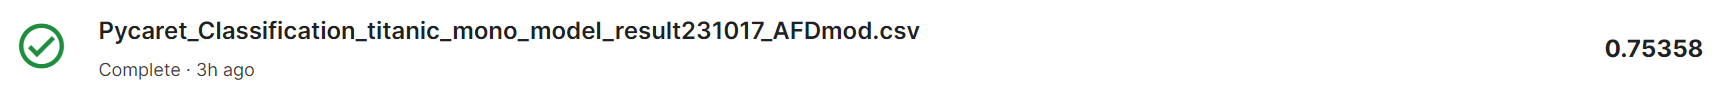

## 이를 통해 알 수 있었던 것: 앙상블이 답이 아닐 수 있음

* 일단 Age, Fare 범주형 변환 시행하지 말고, 

* Age, Fare 스케일링하고

* Deck 범주형 2번 변환 하지 말고 시행해보기

> * 원핫인코딩의 이점
> * 인코딩된 벡터는 직관적으로 이해하기 쉽다.
> * 각 범주가 하나의 차원을 나타내므로 범주의 의미를 보존함

> * 단점

> 메모리 증가
> * 범주의 수가 많고 데이터가 희소한 경우에는 벡터의 크기가 커질 수 있어 메모리와 계산 비용이 증가

> 정보 손실
> * 범주 간의 관계를 고려하지 않기 때문에 일부 정보가 손실될 수 있습니다.

> 그렇다면 나는 라벨 인코딩을 해보려 함

바로 실행해보기

In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# load dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]
all_df = pd.concat([train_df, test_df.reset_index(drop=True)], axis=0)


# Embark 결측치 처리
all_df['Embarked'] = all_df['Embarked'].fillna('S')
train_df['Embarked'] = train_df['Embarked'].fillna('S')

# 갑판을 바탕으로 범주화 -> A B C D E F G T n
all_df['Deck'] = all_df.Cabin.apply(lambda x: str(x)[0])
all_df['Deck']
train_df['Deck'] = train_df.Cabin.apply(lambda x: str(x)[0])
train_df['Deck']
test_df['Deck'] = test_df.Cabin.apply(lambda x: str(x)[0])
test_df['Deck']
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
all_df = all_df.drop(['Cabin'], axis=1)

# 비슷한 특징 범주화 하지 말자
# train_df['Deck'] = train_df['Deck'].replace(['A','B','C'], 'ABC')
# train_df['Deck'] = train_df['Deck'].replace(['D','E'], 'DE')
# train_df['Deck'] = train_df['Deck'].replace(['F','G'], 'FG')
# train_df['Deck'] = train_df['Deck'].replace(['n','T'], 'NT')
# test_df['Deck'] = test_df['Deck'].replace(['A','B','C'], 'ABC')
# test_df['Deck'] = test_df['Deck'].replace(['D','E'], 'DE')
# test_df['Deck'] = test_df['Deck'].replace(['F','G'], 'FG')
# test_df['Deck'] = test_df['Deck'].replace('n', 'NT')

# Age 결측치 처리

# 0세는 1세로 변환
all_df.loc[all_df.Age <= 1, 'Age'] = 1
train_df.loc[train_df.Age <= 1, 'Age'] = 1
test_df.loc[test_df.Age <= 1, 'Age'] = 1

# median으로 처리
all_df['Age'].fillna(all_df['Age'].median(), inplace=True)
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

# float 형을 int형으로 변환하는데 반올림 자동 실행
all_df['Age'] = all_df['Age'].astype('int')
train_df['Age'] = train_df['Age'].astype('int')
test_df['Age'] = test_df['Age'].astype('int')

# Fare 결측치 처리 -> 평균으로 하였음
all_df['Fare'] = all_df['Fare'].fillna(7.4917)
test_df['Fare'] = test_df['Fare'].fillna(7.4917)

# 티켓 값 삭제 -> 필요 없는 변수 삭제
all_df = all_df.drop(['Ticket'], axis=1)
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
combine = [train_df, test_df]

# 파생변수 변환과정

# Name -> Title re 정규식 문법 사용하여 변환
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# 작은 값 가진 호칭은 너무 많아서 하나로 정리하기 Rare
# Mrs, Miss, Master, Mr, Rare 5개 범주
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',
                                                 'Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev',
                                                 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# train에서 PassengerId는 삭제하기
# Name도 쓰임을 다해 삭제하기
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

# SibSp + Parch + 1 = Family 
# Family는 0명이 많기 때문에 Alone으로 변환 2명 이상 시 0, 1명은 1로 코딩
for dataset in combine:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['Alone'] = 0
    dataset.loc[dataset['Family'] == 1, 'Alone'] = 1

# SibSp, Parch, Family 삭제하기
train_df = train_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'Family'], axis=1)
combine = [train_df, test_df]

# Age -> Age 범주화 하지말기
# train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# for dataset in combine:
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age']

# AgeBand 삭제
# train_df = train_df.drop(['AgeBand'], axis=1)
# combine = [train_df, test_df]

# Fare -> Fare 범주화
# train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
# for dataset in combine:
#     dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
#     dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare']= 1
#     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']  = 2
#     dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
#     dataset['Fare'] = dataset['Fare'].astype(int)

# FareBand 삭제
# train_df = train_df.drop(['FareBand'], axis=1)
# combine = [train_df, test_df]

# 인코딩 작업
# 변수 정리
# 종속변수

# 범주형 int 생존 여부 [Survived] 0, 1

# 독립변수 

# - 수치형 2

# Age 이산형 데이터 범위 min max 설명 피룡
# Fare 이산형임 데이터 범위 min max 설명 필요

# - 범주형 5

# int 숫자형
# Alone 0, 1                          :  동승자 여부 2명 이상 동승, 1명 승선, 서열 존재하지 않음
# Pclass 0, 1, 2                      :  사회 경제적 지위 값 가격 3등실 , 2등실, 1등실, 서열 존재

# object 문자형
# Embarked S C Q                      :  S 영국 C 프랑스 Q 아일랜드, 서열 존재하지 않음
# Deck A B C D E F G nT               :  갑판의 위치, n은 결측치, 서열 존재하지 않음
# Title Mrs, Miss, Master, Mr, Rare   :  호칭, 서열 존재하지 않음

# 데이터 원핫 인코딩 -> 서열이 존재하지 않는 경우에 사용하기 때문에 원핫 인코딩 사용
# 다중공선성 해결하기 위해 생성된 컬럼수 -1만큼의 컬럼만 사용해야 함
# drop_first=True 옵션 필히 설정하기

# encoded_train_data = pd.get_dummies(train_df, drop_first=True)
# encoded_test_data = pd.get_dummies(test_df, drop_first=True)

# https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769
# 그러나!!! 결정트리에서는 이러한 숫자의 특성을 반영을 하지 않아 사용하기 적절하다는 것이 중론...
# (특히 gradient Boosting Decison tree에서는 Label encoder 기법이 기본적인 방법
# 진짜인지 실험해보자

# 범주형 변수 인코딩 -> 라벨 인코딩 안 돼서 손으로 함

# Sex
train_df['Sex'] = train_df['Sex'].map( {'female' : 0, 'male' : 1} ).astype(int)
test_df['Sex'] = test_df['Sex'].map( {'female' : 0, 'male' : 1} ).astype(int)

# Pclass
train_df['Pclass'] = train_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)
test_df['Pclass'] = test_df['Pclass'].map( {1 : 2, 2 : 1, 3 : 0} ).astype(int)

# Embarked S C Q
train_df['Embarked'] = train_df['Embarked'].map( {'S' : 0, 'C' : 1, 'Q' : 2} ).astype(int)
test_df['Embarked'] = test_df['Embarked'].map( {'S' : 0, 'C' : 1, 'Q' : 2} ).astype(int)

# Deck A B C D E F G nT
train_df['Deck'] = train_df['Deck'].map( {"B" : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'T' : 7, "A" : 8, 'n' : 0} )
test_df['Deck'] = test_df['Deck'].map( {"B" : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'T' : 7, "A" : 8, 'n' : 0} )

# Title Mrs, Miss, Master, Mr, Rare
train_df['Title'] = train_df['Title'].map( { "Mrs" : 0, 'Miss' : 1, 'Master' : 2, 'Mr' : 3, 'Rare' : 4 } ).astype(int)
test_df['Title'] = test_df['Title'].map( { "Mrs" : 0, 'Miss' : 1, 'Master' : 2, 'Mr' : 3, 'Rare' : 4 } ).astype(int)

encoded_train_data = train_df.copy(deep = True)
encoded_test_data = test_df.copy(deep = True)

## 데이터 정규화 -> 이상치에 강한 정규화 방법 boxplot과 연관 있음, 

# Age와 Fare 값의 스케일이 다른 변수보다 커서 스케일링 시행함
from sklearn.preprocessing import StandardScaler, RobustScaler
rs = RobustScaler()

# Age 스케일링

encoded_train_data_scaled = encoded_train_data.copy(deep=True)
encoded_train_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_train_data_scaled[["Age"]])

encoded_test_data_scaled = encoded_test_data.copy(deep=True)
encoded_test_data_scaled[["Age_scaled"]] = rs.fit_transform(encoded_test_data_scaled[["Age"]])

# Age 삭제
encoded_train_data_scaled = encoded_train_data_scaled.drop("Age", axis=1)
encoded_test_data_scaled = encoded_test_data_scaled.drop("Age", axis=1)

# Fare 스케일링

encoded_train_data_scaled = encoded_train_data.copy(deep=True)
encoded_train_data_scaled[["Fare_scaled"]] = rs.fit_transform(encoded_train_data_scaled[["Fare"]])

encoded_test_data_scaled = encoded_test_data.copy(deep=True)
encoded_test_data_scaled[["Fare_scaled"]] = rs.fit_transform(encoded_test_data_scaled[["Fare"]])

# Fare 삭제
encoded_train_data_scaled = encoded_train_data_scaled.drop("Fare", axis=1)
encoded_test_data_scaled = encoded_test_data_scaled.drop("Fare", axis=1)


# 데이터 분리 (학습 / 검증)
X_train = encoded_train_data_scaled.drop("Survived", axis=1)
Y_train = encoded_train_data_scaled["Survived"]
X_test  = encoded_test_data_scaled.drop("PassengerId", axis=1).copy()

from sklearn.model_selection import train_test_split

#train set 을 한번 더 나누어서 validation set 또한 만들어 낼 수 있습니다. 
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.2, 
                                                  shuffle=True, random_state=777)


## 모델 학습 및 평가 
# 모델 성능 평가 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
def get_classfication_evalulator(y_test, pred):
    ## 오차행렬
    confusion = confusion_matrix(y_test, pred)
    ## 정확도
    accuracy = accuracy_score(y_test, pred)
    ## 정밀도
    precision = precision_score(y_test, pred)
    ## 재현율
    recall = recall_score(y_test, pred)
    ## F1 스코어
    f1 = f1_score(y_test, pred)
    print('------ 오차행렬 -------\n', confusion)
    print('\n정확도(accuracy): {:.4f}, 정밀도(precision): {:.4f}, 재현율(recall): {:.4f}, F1: {:.4f}'.format(accuracy, precision, recall, f1))
    print('---------------------\n')
    

# ROC_AUC 그래프 시각화
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        pred_proba_c1 = model.predict_proba(X_test)[:, 1]
        fprs, tprs, _ = roc_curve(y_test, pred_proba_c1)
        roc_auc = roc_auc_score(y_test, pred_proba_c1)

        plt.plot(fprs, tprs, label=f'{model_name} (ROC_AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR (Recall)')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

In [ ]:
encoded_train_data_scaled.head(10)

In [ ]:
encoded_train_data_scaled.columns # 총 9개의 변수 생성

In [ ]:
# 최종적으로 분할된 각 test, validation, test set 을 모두 출력 
print("x_train:", x_train)
print("y_train:", y_train)
print("x_val:", x_val)
print("y_val:", y_val)
print("X_test:", X_test)

In [ ]:
from traitlets.config.application import Application
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: _LGBM_ScikitCustomObjectiveFunction | str | None = None, class_weight: Dict[Unknown, Unknown] | str | None = None, min_split_gain: float = 0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1, subsample_freq: int = 0, colsample_bytree: float = 1, reg_alpha: float = 0, reg_lambda: float = 0, random_state: int | RandomState | None = None, n_jobs: int | None = None, importance_type: str = 'split', **kwargs: Unknown)
# https://blog.naver.com/diana-0/223153560097
# https://blog.naver.com/dlwoduq234/223056037863
# https://blog.naver.com/charzim0611/222930745760

# 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
# 그래디언트 부스팅 발전 버전인 xgboost와 더 속도 높은 lightgbm 사용해보기

# pycaret 결과 [model_gbc, model_lightgbm, model_xgboost, model_lr, model_rf]가 좋음

lg_clf = LGBMClassifier(random_state=777,application='binary', metric='AUC')
xg_clf = XGBClassifier(random_state=777)
dt_clf = DecisionTreeClassifier(random_state=777)
rf_clf = RandomForestClassifier(random_state=777)
lr_clf = LogisticRegression(random_state=777)

# x_train, x_val, y_train, y_val
# X_train, X_test, y_train, y_test

# lightGBMClassifier 학습/예측/평가
lg_clf.fit(x_train, y_train)
lg_pred = lg_clf.predict(x_val)
print('🌲 LGBMClassifier 평가\n')
get_classfication_evalulator(y_val, lg_pred)

# XgboostClassifier 학습/예측/평가
xg_clf.fit(x_train, y_train)
xg_pred = xg_clf.predict(x_val)
print('🌲 XGBClassifier 평가\n')
get_classfication_evalulator(y_val, xg_pred)

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_val)
print('🌲 DecisionTreeClassifier 평가\n')
get_classfication_evalulator(y_val, dt_pred)

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_val)
print('🌳🌳 RandomForestClassifier 평가\n')
get_classfication_evalulator(y_val, rf_pred)

# LogisticRegression 학습/예측/평가
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_val)
print('🧐 LogisticRegression 평가')
get_classfication_evalulator(y_val, lr_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

xg_param_grid = {
    "max_depth": [10,30,50],
    "min_child_weight" : [1,3,6,10],
    "n_estimators": [200,300,500,1000],
     'colsample_bytree':[0.5, 0.75]
              } 

# https://knowallworld.tistory.com/448
lg_param_grid = {
    'max_depth': [3, 4],                        # 트리의 최대 깊이
    'learning_rate': [0.01, 0.05],               # 학습률
    'n_estimators': [200, 300, 400],             # 트리의 개수
    'min_child_samples': [1, 2, 3, 4],           # 리프 노드에 필요한 최소 샘플 수
    'subsample': [0.05, 0.01],                   # 트리를 학습할 때 사용할 샘플링 비율
    'colsample_bytree': [0.8,0.9, 1],                # 트리를 학습할 때 사용할 특성의 비율
    'reg_alpha': [0.1,0.2],                     # L1 정규화 항의 가중치
    'reg_lambda': [0.0, 0.1],                         # L2 정규화 항의 가중치
    'ManchesterUNITED': [2, 3]                   # 유효하지 않은 매개변수 (무시됨)
}

# https://knowallworld.tistory.com/447
dt_param_grid = {
    'max_depth': [2, 3, 5, 10],                        # 의사결정트리의 최대 깊이
    'min_samples_split': [1, 2, 3, 5, 7, 10],            # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [0, 1, 2, 3, 4, 5, 6],           # 리프 노드에 필요한 최소 샘플 수
    'ccp_alpha': [0.0, 0.1, 0.2],                     # Cost-Complexity Pruning (CCP) 알고리즘에 대한 복잡성 매개변수
    # 'class_weight': [None, 'balanced'],               # 클래스별 가중치 (None: 균등한 가중치, 'balanced': 불균등한 가중치)
    'criterion': ['gini', 'entropy'],                  # 불순도(impurity) 계산에 사용할 기준 ('gini': Gini 불순도, 'entropy': 엔트로피)
    # 'max_features': ['auto', 'sqrt', 'log2', None],    # 각 분할에서 고려할 최대 특성 개수 ('auto': sqrt(features), 'sqrt': sqrt(features), 'log2': log2(features), None: 모든 특성)
    'max_leaf_nodes': [1, 5, 10, 15],               # 리프 노드의 최대 개수 (None: 제한 없음, 정수 값: 리프 노드의 최대 개수)
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],          # 분할 기준으로서 필요한 최소 불순도 감소량
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],       # 리프 노드의 최소 가중치 비율
    'random_state': [42],                              # 난수 발생 시드 값
    'splitter': ['best', 'random']                     # 분할 기준을 선택하는 전략 ('best': 최적의 분할, 'random': 무작위 분할)
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 7, 10, 20],
    'min_samples_split': [2, 3, 6],
    'min_samples_leaf': [1, 5, 6, 8]
}

# https://knowallworld.tistory.com/446
lr_param_grid = {
    'penalty': ['l1', 'l2'],                      # 규제 유형 ('l1': L1 규제, 'l2': L2 규제)
    'C': [0.1, 1.0, 10.0],                        # 규제 강도의 역수 (값이 작을수록 강한 규제)
    'solver': ['lbfgs', 'newton-cg', 'saga'],      # 최적화에 사용할 알고리즘
    'max_iter': [500, 700, 1000],                 # 최대 반복 횟수
    'class_weight': [None, 'balanced'],            # 클래스 가중치 (None: 균등한 가중치, 'balanced': 불균등한 가중치)
    'dual': [True, False],                         # 이중 문제 유형 (True: 이중 문제 사용, False: 원 문제 사용)
    # 'fit_intercept': [True, False],                # 절편(intercept) 학습 여부
    # 'intercept_scaling': [1, 2, 3],                # 절편의 스케일링 비율
    # 'l1_ratio': [None, 0.2, 0.5],                  # L1 규제와 L2 규제 사이의 혼합 비율
    # 'multi_class': ['auto', 'ovr', 'multinomial'], # 다중 클래스 처리 방법 ('auto': 자동 선택, 'ovr': 일대다, 'multinomial': 다항 분류)
    'n_jobs': [None, -1],                          # 병렬 처리에 사용할 CPU 코어 수 (None: 1개, -1: 모든 코어)
    'random_state': [42],                          # 난수 발생 시드 값
    'tol': [0.0001, 0.001, 0.01],                  # 수렴 기준 (작을수록 더 정밀한 계산)
    # 'verbose': [0, 1, 2],                          # 출력 메시지 레벨 (0: 출력 없음, 1: 진행 상황 메시지, 2: 모든 메시지)
    # 'warm_start': [True, False]                    # 이전 학습 결과를 재사용하여 학습 계속 여부
}

grid_lg_clf = GridSearchCV(lg_clf, param_grid=lg_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_xg_clf = GridSearchCV(xg_clf, param_grid=xg_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_dt_clf = GridSearchCV(dt_clf, param_grid=dt_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_rf_clf = GridSearchCV(rf_clf, param_grid=rf_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)
grid_lr_clf = GridSearchCV(lr_clf, param_grid=lr_param_grid, 
                           scoring='accuracy', refit=True, cv=5, n_jobs=-1)

grid_lg_clf.fit(x_train, y_train)
grid_xg_clf.fit(x_train, y_train)
grid_dt_clf.fit(x_train, y_train)
grid_rf_clf.fit(x_train, y_train)
grid_lr_clf.fit(x_train, y_train)

print('LGBMClassifier - GridSearchCV 최적 하이퍼 파라미터:', grid_lg_clf.best_params_)
print('LGBMClassifier - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lg_clf.best_score_))

print('XGBClassifier - GridSearchCV 최적 하이퍼 파라미터:', grid_xg_clf.best_params_)
print('XGBClassifier - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_xg_clf.best_score_))

print('Decision Tree - GridSearchCV 최적 하이퍼 파라미터:', grid_dt_clf.best_params_)
print('Decision Tree - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dt_clf.best_score_))

print('Random Forest - GridSearchCV 최적 하이퍼 파라미터:', grid_rf_clf.best_params_)
print('Random Forest - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rf_clf.best_score_))

print('Logistic Regression - GridSearchCV 최적 하이퍼 파라미터:', grid_lr_clf.best_params_)
print('Logistic Regression - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lr_clf.best_score_))

best_lg_clf = grid_lg_clf.best_estimator_
best_xg_clf = grid_xg_clf.best_estimator_
best_dt_clf = grid_dt_clf.best_estimator_
best_rf_clf = grid_rf_clf.best_estimator_
best_lr_clf = grid_lr_clf.best_estimator_

lg_predictions = best_lg_clf.predict(x_val)
xg_predictions = best_xg_clf.predict(x_val)
dt_predictions = best_dt_clf.predict(x_val)
rf_predictions = best_rf_clf.predict(x_val)
lr_predictions = best_lr_clf.predict(x_val)

lg_accuracy = accuracy_score(y_val, lg_predictions)
xg_accuracy = accuracy_score(y_val, xg_predictions)
dt_accuracy = accuracy_score(y_val, dt_predictions)
rf_accuracy = accuracy_score(y_val, rf_predictions)
lr_accuracy = accuracy_score(y_val, lr_predictions)

print('LGBMClassifier - 테스트셋에서 정확도: {0:.4f}'.format(lg_accuracy))
print('XGBClassifier - 테스트셋에서 정확도: {0:.4f}'.format(xg_accuracy))
print('Decision Tree - 테스트셋에서 정확도: {0:.4f}'.format(dt_accuracy))
print('Random Forest - 테스트셋에서 정확도: {0:.4f}'.format(rf_accuracy))

print('Logistic Regression - 테스트셋에서 정확도: {0:.4f}'.format(lr_accuracy))

In [ ]:
# ROC 곡선 그래프
# True Positive Rate를 Y축, False Positive Rate를 X축으로 하여 
# 모델이 양성/긍정으로 예측했을 때 얼마나 잘 맞추고 있는지를 설명
# ROC 곡선을 통해 모델의 성능을 평가하거나 최적의 분류기준(threshold)을 찾기
# ROC curve가 왼쪽 상단(0,1) 방향으로 더 휘어질 수록 예측성능이 뛰어난 모델

# 이진 분류 성능 평가 지표로 많이 사용됨

models = {
    'LGBMClassifier': best_lg_clf,
    'XGBClassifier': best_xg_clf,
    'Logistic Regression': best_lr_clf,
    'Decision Tree': best_dt_clf,
    'Random Forest': best_rf_clf
}

plot_roc_curves(models, x_val, y_val)

In [ ]:
# x_train, x_val, y_train, y_val
# X_train, X_test, y_train, y_test
### 전체 데이터 학습
xg_clf.fit(X_train, Y_train)

In [ ]:
X_test

## 예측을 수행한다.
pred = xg_clf.predict(X_test)

## 예측 결과를 Survived 컬럼으로 입력한다.
X_test['Survived'] = pred

## 예측 결과를 PassengerId와 Survived 컬럼으로만 제한해 CSV 파일로 저장한다.
X_test['PassengerId'] = test_df["PassengerId"]
submission = X_test[['PassengerId','Survived']]
submission.to_csv('Pycaret_Classification_titanic_mono_model_result231017_AFDmod_xg.csv', index=False) 

## 0.71291 점수를 얻었다.

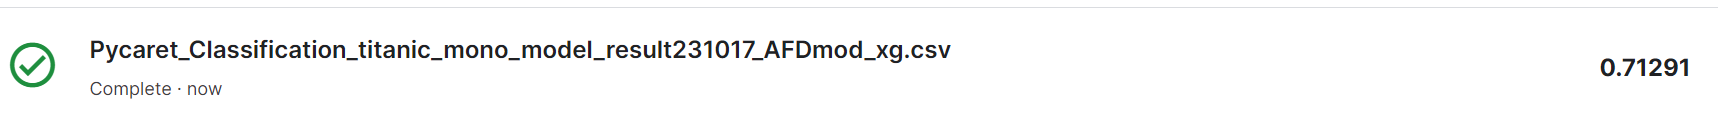